# **Import Libraries**

In [1]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
from sklearn.metrics import confusion_matrix, f1_score,classification_report
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

#!pip install pyLDAvis==2.1.2
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Get the raw text, partition it, label it**

## **Function to get the raw text from a Gutenberg book url**

In [2]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

## **Function to get the part of the raw text between the end of the author name and the begining of the closing statement**

All Gutenberg books start with the opening statement  "START OF THE PROJECT GUTENBERG EBOOK" followed by the title and author name, and end with the closing statement "END OF THE PROJECT GUTENBERG EBOOK". To do any NLP effectively, we should extract partitions from the raw text that lies between the end of the author name and the begining of the closing statement.

In [3]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

## **Function to break down the raw text into a list of tokens i.e. words**

In [4]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

## **Function to extract a specified number of random partitions from a book where each partition contains a specified number of words**

In [5]:
random.seed(42)
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

## **Function to extract partitions from multiple books and label them as per the book they belong to**

In [6]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

## **Function to extract partitions from multiple books and save them in a dataframe and csv file**

In [7]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

## **Extraction of 200 random partitions of 150 words each from 6 books from Gutenberg's Digital Collection**

In [8]:
# Book 1 Details
url1 = 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt'
title1= 'Pride and Prejudice'
author1= 'Jane Austen'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/345/pg345.txt'
title2= 'Dracula'
author2= 'Bram Stoker'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/84/pg84.txt'
title3= 'Frankenstein'
author3= 'Mary Wollstonecraft (Godwin) Shelley'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/174/pg174.txt'
title4= 'The Picture of Dorian Gray'
author4= 'Oscar Wilde'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/120/pg120.txt'
title5= 'Treasure Island'
author5= 'Robert Louis Stevenson'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/1661/pg1661.txt'
title6= 'The Adventures of Sherlock Holmes'
author6= 'Arthur Conan Doyle'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'Pride and Prejudice',
  'author': 'Jane Austen',
  'url': 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt',
  'label': 'a'},
 {'title': 'Dracula',
  'author': 'Bram Stoker',
  'url': 'https://www.gutenberg.org/cache/epub/345/pg345.txt',
  'label': 'b'},
 {'title': 'Frankenstein',
  'author': 'Mary Wollstonecraft (Godwin) Shelley',
  'url': 'https://www.gutenberg.org/cache/epub/84/pg84.txt',
  'label': 'c'},
 {'title': 'The Picture of Dorian Gray',
  'author': 'Oscar Wilde',
  'url': 'https://www.gutenberg.org/cache/epub/174/pg174.txt',
  'label': 'd'},
 {'title': 'Treasure Island',
  'author': 'Robert Louis Stevenson',
  'url': 'https://www.gutenberg.org/cache/epub/120/pg120.txt',
  'label': 'e'},
 {'title': 'The Adventures of Sherlock Holmes',
  'author': 'Arthur Conan Doyle',
  'url': 'https://www.gutenberg.org/cache/epub/1661/pg1661.txt',
  'label': 'f'}]

In [9]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=150)

In [10]:
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  
0     library ) he started back , and , begging pard...  
1     of Mr. Bingley . They attacked him in various ...  
2     pleases. ” “ And if not able to please himself...  
3     a mile across the park . Every park has its be...  
4     visit ; and when she rose to take leave , Eliz...  
...                                                 ...  
1195  not tell what indirect or political influence ...  
1196  in Australia. ” “ What of the rat , then ? ” S...  
1197  , “ I say now , as I said then , that a man sh...  
1198  bite . I had no time to think of it. ” “ And h...  
1199  the lamp and examined it intently . I had left...  

[1200 rows x 4 columns]

# **Clean up the data: remove punctuation, tokenize, remove stopwords, stem/lemmatize**

In [11]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
1     of Mr. Bingley . They attacked him in various ...   
2     pleases. ” “ And if not able to please himself...   
3     a mile across the park . Every park has its be...   
4     visit ; and when she rose to take leave , Eliz...   
...                                                 ...   
1195  not tell what indirect or political influence ...   
1196  in Australia. ” “ What of the rat , then ? ” S...   
1197  , “ I say now , as I said then , that a man sh...   
1198  bite . I had no time to think of it. ” “ And h...   
1199  the lamp and examined it intently . I had left...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
1     mr bingley attack variou way barefac question ...   
2     pleas abl pleas arrang least great pleasur pow...   
3     mile across park everi park beauti prospect el...   
4     visit rose take leav elizabeth asham mother un...   
...                                                 ...   
1195  tell indirect polit influenc might brought bea...   
1196  australia rat sherlock holm took fold paper po...   
1197  say said man keep littl brainatt stock furnitu...   
1198  bite time think succeed well clue hollow hand ...   
1199  lamp examin intent left chair gaze shoulder en...   

                                   Partition_lemmatized  
0     library started back begging pardon protested ...  
1     mr bingley attacked various way barefaced ques...  
2     plea able please arrangement least great pleas...  
3     mile across park every park beauty prospect el...  
4     visit rose take leave elizabeth ashamed mother...  
...                                                 ...  
1195  tell indirect political influence might brough...  
1196  australia rat sherlock holmes took folded pape...  
1197  say said man keep little brainattic stocked fu...  
1198  bite time think succeeded well clue hollow han...  
1199  lamp examined intently left chair gazing shoul...  

[1200 rows x 6 columns]

# **Data Analysis**

## **Length Analysis**

Examining the length of the text is crucial, as it entails a straightforward calculation that can yield valuable insights. For instance, the length itself might become the sole feature necessary for model construction.

Various measures exist for assessing the length of text data. Several examples include:

Word count: This involves tallying the number of tokens in the text, with tokens being separated by spaces.

Character count: It entails summing the number of characters in each token.

Sentence count: This measure involves counting the number of sentences, with sentences separated by periods.

Average word length: Calculated as the sum of word lengths divided by the total number of words, where word lengths are determined by the character count.

Average sentence length: Determined by dividing the sum of sentence lengths by the total number of sentences, where sentence lengths are measured in terms of word count.

In [12]:
# New features: Word count, Character count, Sentence count, Average word length, Average sentence length
data['Word_count']= data['Partition_lemmatized'].apply(lambda x: len(x.split(" ")))
data['Character_count']= data['Partition_lemmatized'].apply(lambda x: sum(len(word) for word in x.split(" ")))
data ['Sentence_count']= data['Partition'].apply(lambda x: len(x.split(".")))
data['Avg_word_length']= data['Character_count']/data['Word_count']
data['Avg_sentence_length']= data['Word_count']/data['Sentence_count']

In [13]:
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
1     of Mr. Bingley . They attacked him in various ...   
2     pleases. ” “ And if not able to please himself...   
3     a mile across the park . Every park has its be...   
4     visit ; and when she rose to take leave , Eliz...   
...                                                 ...   
1195  not tell what indirect or political influence ...   
1196  in Australia. ” “ What of the rat , then ? ” S...   
1197  , “ I say now , as I said then , that a man sh...   
1198  bite . I had no time to think of it. ” “ And h...   
1199  the lamp and examined it intently . I had left...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
1     mr bingley attack variou way barefac question ...   
2     pleas abl pleas arrang least great pleasur pow...   
3     mile across park everi park beauti prospect el...   
4     visit rose take leav elizabeth asham mother un...   
...                                                 ...   
1195  tell indirect polit influenc might brought bea...   
1196  australia rat sherlock holm took fold paper po...   
1197  say said man keep littl brainatt stock furnitu...   
1198  bite time think succeed well clue hollow hand ...   
1199  lamp examin intent left chair gaze shoulder en...   

                                   Partition_lemmatized  Word_count  \
0     library started back begging pardon protested ...          64   
1     mr bingley attacked various way barefaced ques...          66   
2     plea able please arrangement least great pleas...          52   
3     mile across park every park beauty prospect el...          72   
4     visit rose take leave elizabeth ashamed mother...          59   
...                                                 ...         ...   
1195  tell indirect political influence might brough...          47   
1196  australia rat sherlock holmes took folded pape...          45   
1197  say said man keep little brainattic stocked fu...          59   
1198  bite time think succeeded well clue hollow han...          52   
1199  lamp examined intently left chair gazing shoul...          49   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  
0                 358               9         5.593750             7.111111  
1                 426              10         6.454545             6.600000  
2                 298              11         5.730769             4.727273  
3                 446               7         6.194444            10.285714  
4                 358               9         6.067797             6.555556  
...               ...             ...              ...                  ...  
1195              250              14         5.319149             3.357143  
1196              246              15         5.466667             3.000000  
1197              324               7         5.491525             8.428571  
1198              278              14         5.346154             3.714286  
1199              304              10         6.204082             4.90

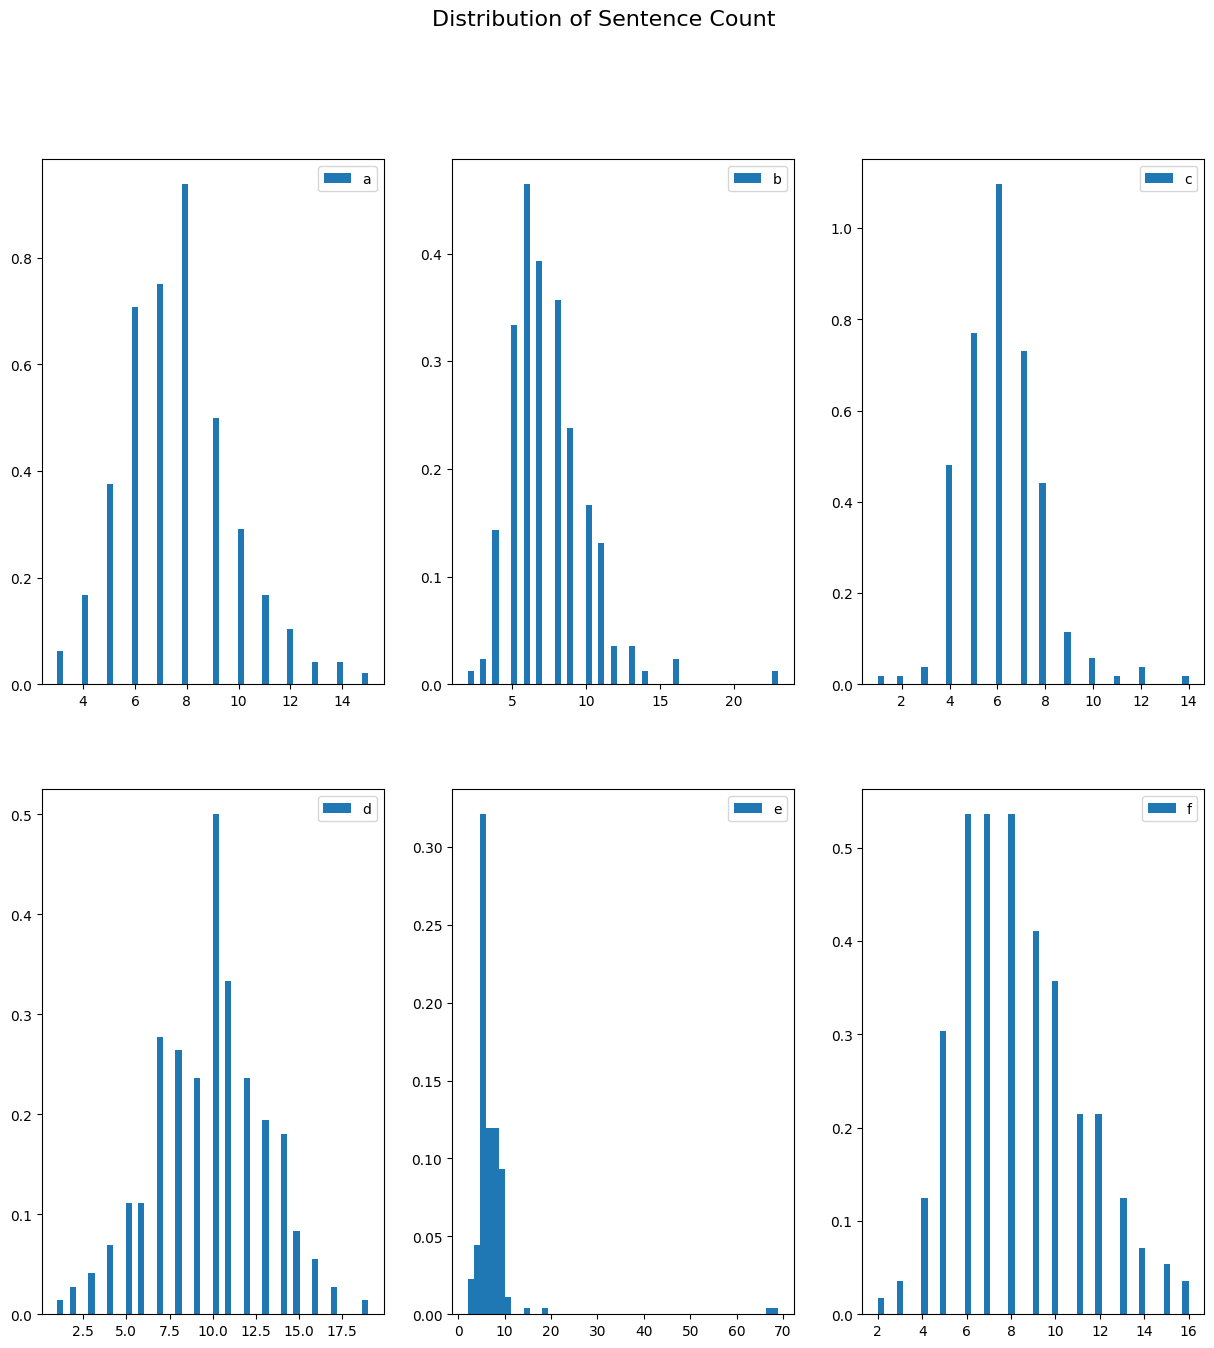

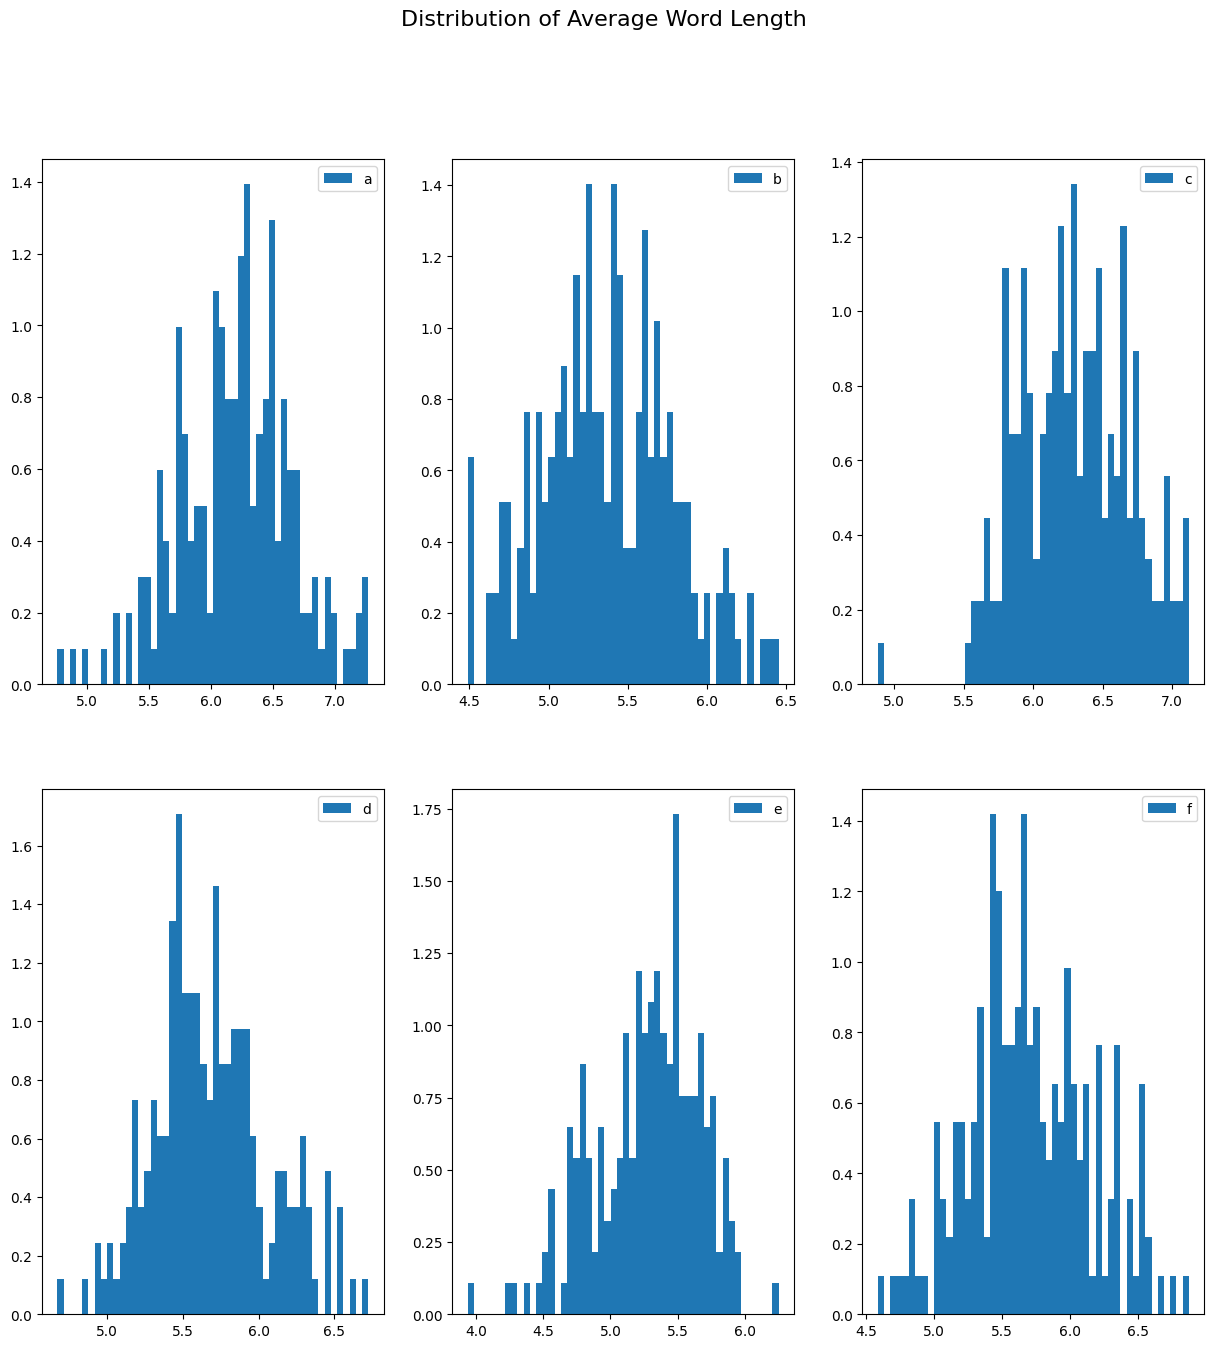

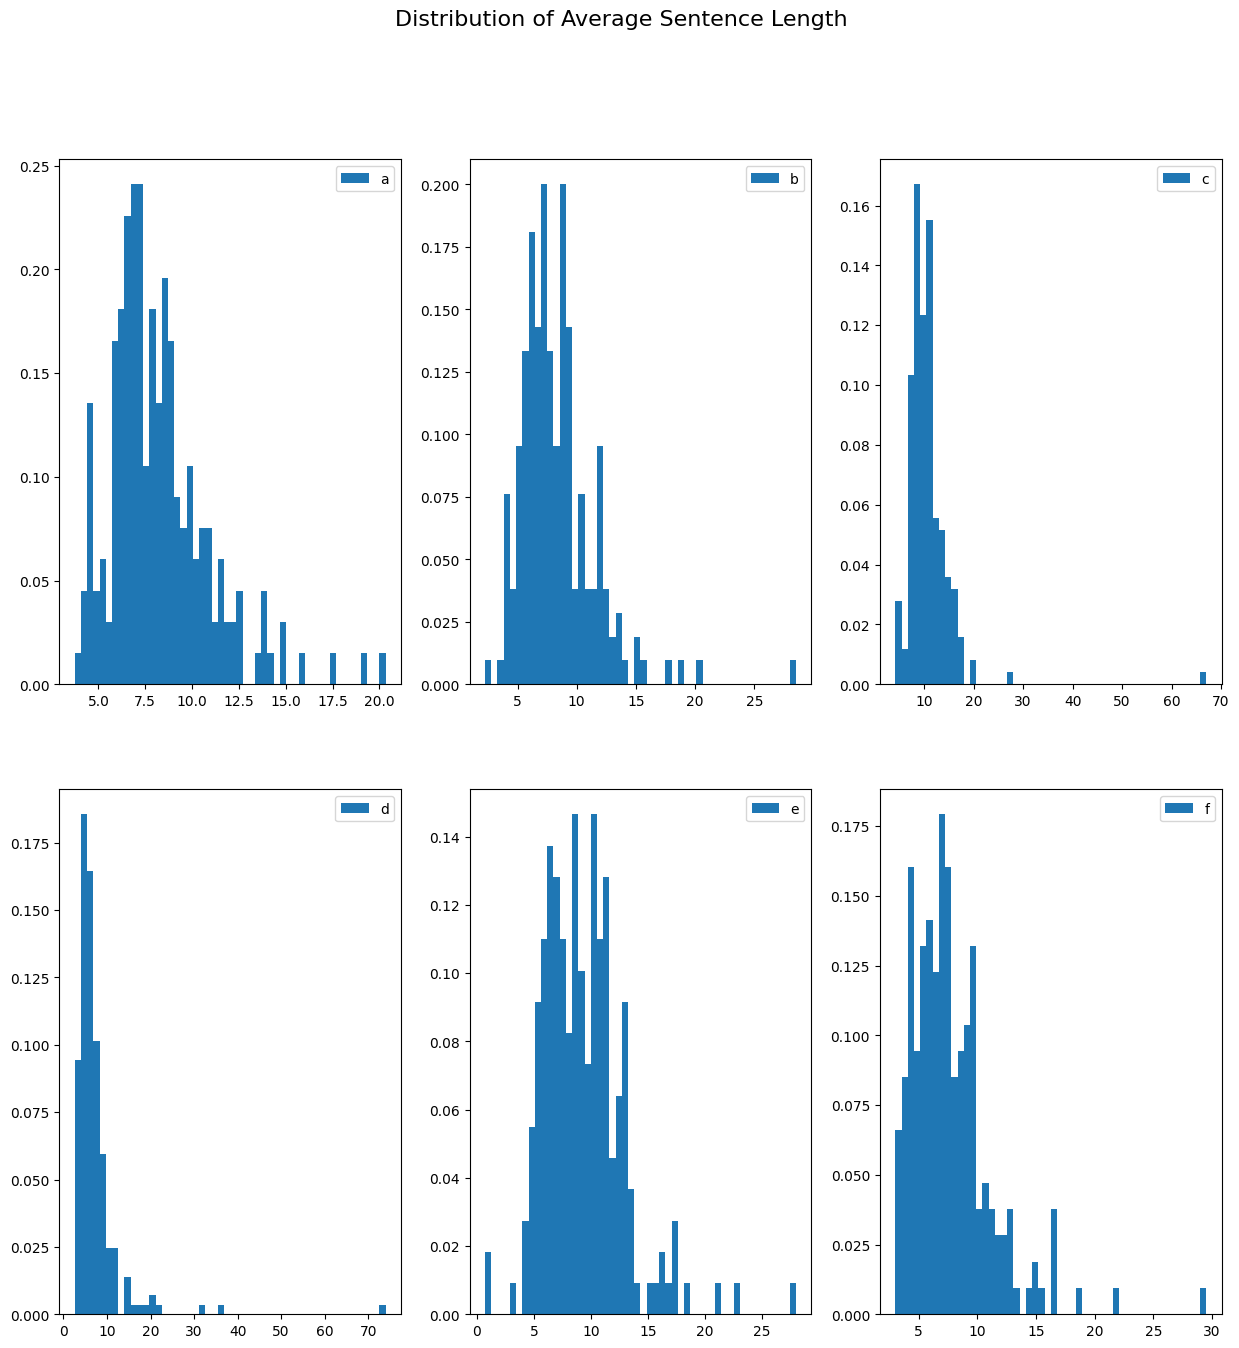

In [14]:
# Evaluation of new features using histograms:
Labels= data['Label'].unique()

# Distribution of Word Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Word Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Word_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Character Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Character Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Character_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Sentence Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentence Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentence_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Word Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Word Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_word_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Sentence Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Sentence Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_sentence_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Sentiment Analysis**

The TextBlob library in Python is a simple natural language processing (NLP) library for processing textual data. The sentiment.polarity attribute of a TextBlob object is used to calculate the sentiment polarity of a text. The sentiment.polarity attribute returns a value between -1 and 1, where:

-1 indicates a negative sentiment,
0 indicates a neutral sentiment, and
1 indicates a positive sentiment.

In [15]:
# New feature: Sentiment Polarity
data['Sentiment_polarity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
1     of Mr. Bingley . They attacked him in various ...   
2     pleases. ” “ And if not able to please himself...   
3     a mile across the park . Every park has its be...   
4     visit ; and when she rose to take leave , Eliz...   
...                                                 ...   
1195  not tell what indirect or political influence ...   
1196  in Australia. ” “ What of the rat , then ? ” S...   
1197  , “ I say now , as I said then , that a man sh...   
1198  bite . I had no time to think of it. ” “ And h...   
1199  the lamp and examined it intently . I had left...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
1     mr bingley attack variou way barefac question ...   
2     pleas abl pleas arrang least great pleasur pow...   
3     mile across park everi park beauti prospect el...   
4     visit rose take leav elizabeth asham mother un...   
...                                                 ...   
1195  tell indirect polit influenc might brought bea...   
1196  australia rat sherlock holm took fold paper po...   
1197  say said man keep littl brainatt stock furnitu...   
1198  bite time think succeed well clue hollow hand ...   
1199  lamp examin intent left chair gaze shoulder en...   

                                   Partition_lemmatized  Word_count  \
0     library started back begging pardon protested ...          64   
1     mr bingley attacked various way barefaced ques...          66   
2     plea able please arrangement least great pleas...          52   
3     mile across park every park beauty prospect el...          72   
4     visit rose take leave elizabeth ashamed mother...          59   
...                                                 ...         ...   
1195  tell indirect political influence might brough...          47   
1196  australia rat sherlock holmes took folded pape...          45   
1197  say said man keep little brainattic stocked fu...          59   
1198  bite time think succeeded well clue hollow han...          52   
1199  lamp examined intently left chair gazing shoul...          49   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 358               9         5.593750             7.111111   
1                 426              10         6.454545             6.600000   
2                 298              11         5.730769             4.727273   
3                 446               7         6.194444            10.285714   
4                 358               9         6.067797             6.555556   
...               ...             ...              ...                  ...   
1195              250              14         5.319149             3.357143   
1196              246              15         5.466667             3.000000   
1197              324               7         5.491525             8.428571   
1198              278              14         5.346154             3.714286   
1199              304              10         6.204082      

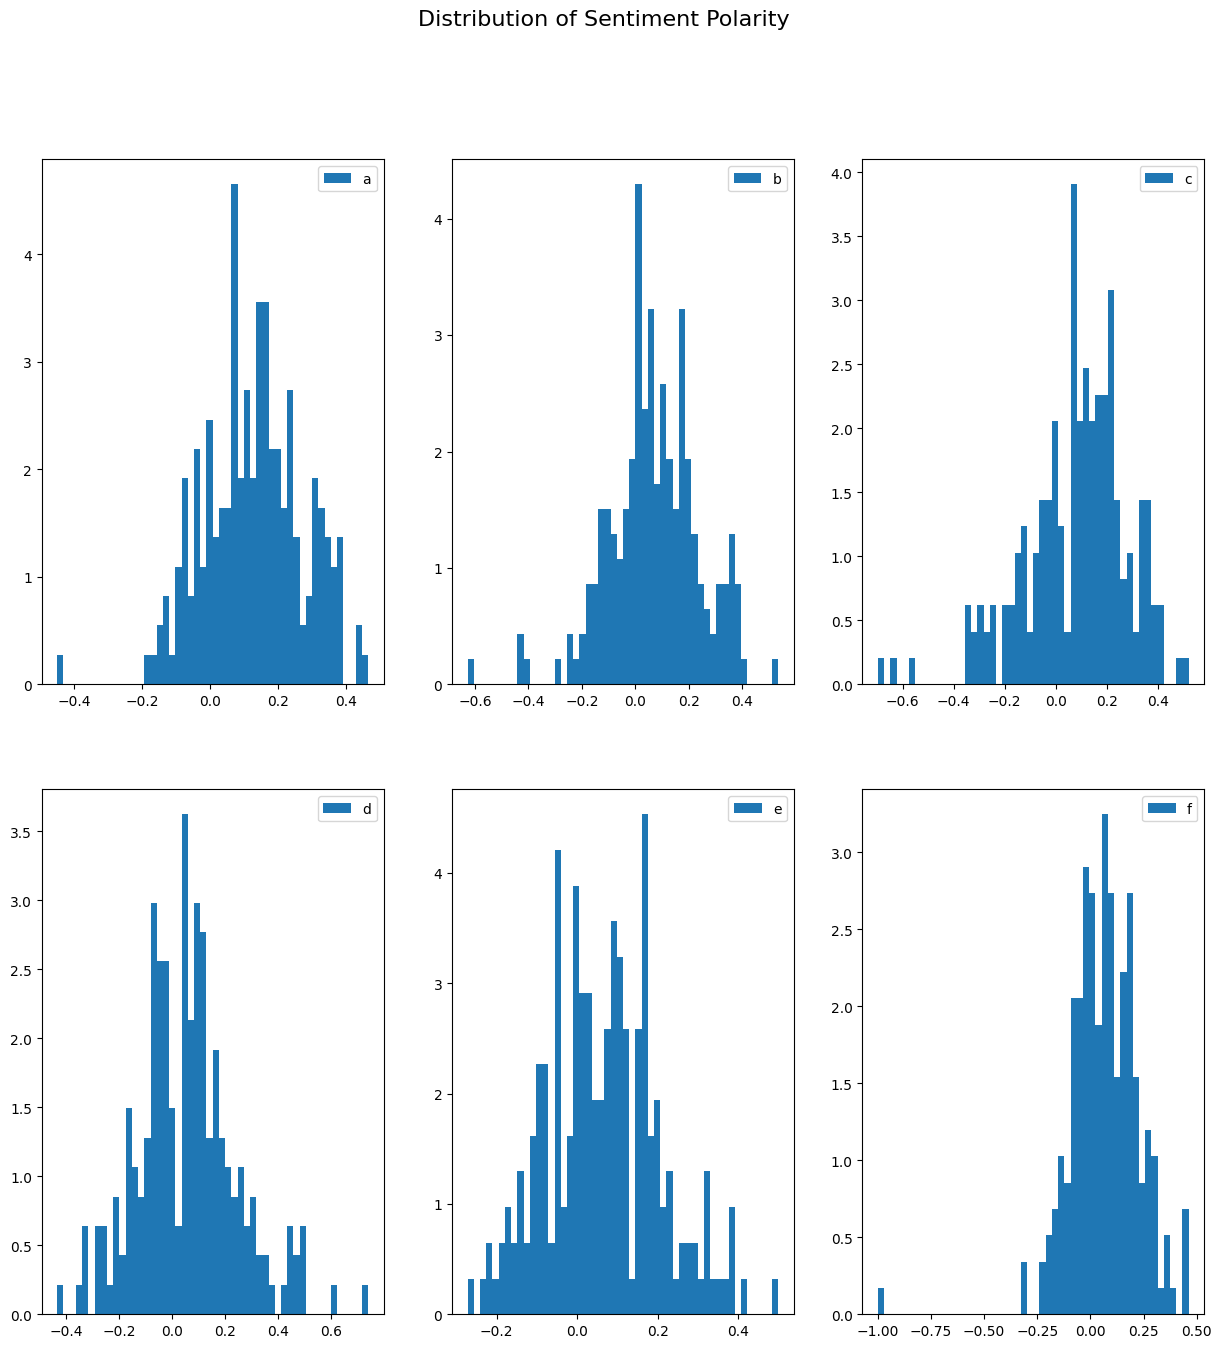

In [16]:
# Evaluation of Sentiment Polarity Feature using histograms:
# Distribution of Sentiment Polarity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Polarity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_polarity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

In [17]:
# New feature: Sentiment Subjectivity
data['Sentiment_subjectivity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
1     of Mr. Bingley . They attacked him in various ...   
2     pleases. ” “ And if not able to please himself...   
3     a mile across the park . Every park has its be...   
4     visit ; and when she rose to take leave , Eliz...   
...                                                 ...   
1195  not tell what indirect or political influence ...   
1196  in Australia. ” “ What of the rat , then ? ” S...   
1197  , “ I say now , as I said then , that a man sh...   
1198  bite . I had no time to think of it. ” “ And h...   
1199  the lamp and examined it intently . I had left...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
1     mr bingley attack variou way barefac question ...   
2     pleas abl pleas arrang least great pleasur pow...   
3     mile across park everi park beauti prospect el...   
4     visit rose take leav elizabeth asham mother un...   
...                                                 ...   
1195  tell indirect polit influenc might brought bea...   
1196  australia rat sherlock holm took fold paper po...   
1197  say said man keep littl brainatt stock furnitu...   
1198  bite time think succeed well clue hollow hand ...   
1199  lamp examin intent left chair gaze shoulder en...   

                                   Partition_lemmatized  Word_count  \
0     library started back begging pardon protested ...          64   
1     mr bingley attacked various way barefaced ques...          66   
2     plea able please arrangement least great pleas...          52   
3     mile across park every park beauty prospect el...          72   
4     visit rose take leave elizabeth ashamed mother...          59   
...                                                 ...         ...   
1195  tell indirect political influence might brough...          47   
1196  australia rat sherlock holmes took folded pape...          45   
1197  say said man keep little brainattic stocked fu...          59   
1198  bite time think succeeded well clue hollow han...          52   
1199  lamp examined intently left chair gazing shoul...          49   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 358               9         5.593750             7.111111   
1                 426              10         6.454545             6.600000   
2                 298              11         5.730769             4.727273   
3                 446               7         6.194444            10.285714   
4                 358               9         6.067797             6.555556   
...               ...             ...              ...                  ...   
1195              250              14         5.319149             3.357143   
1196              246              15         5.466667             3.000000   
1197              324               7         5.491525             8.428571   
1198              278              14         5.346154             3.714286   
1199              304              10         6.204082      

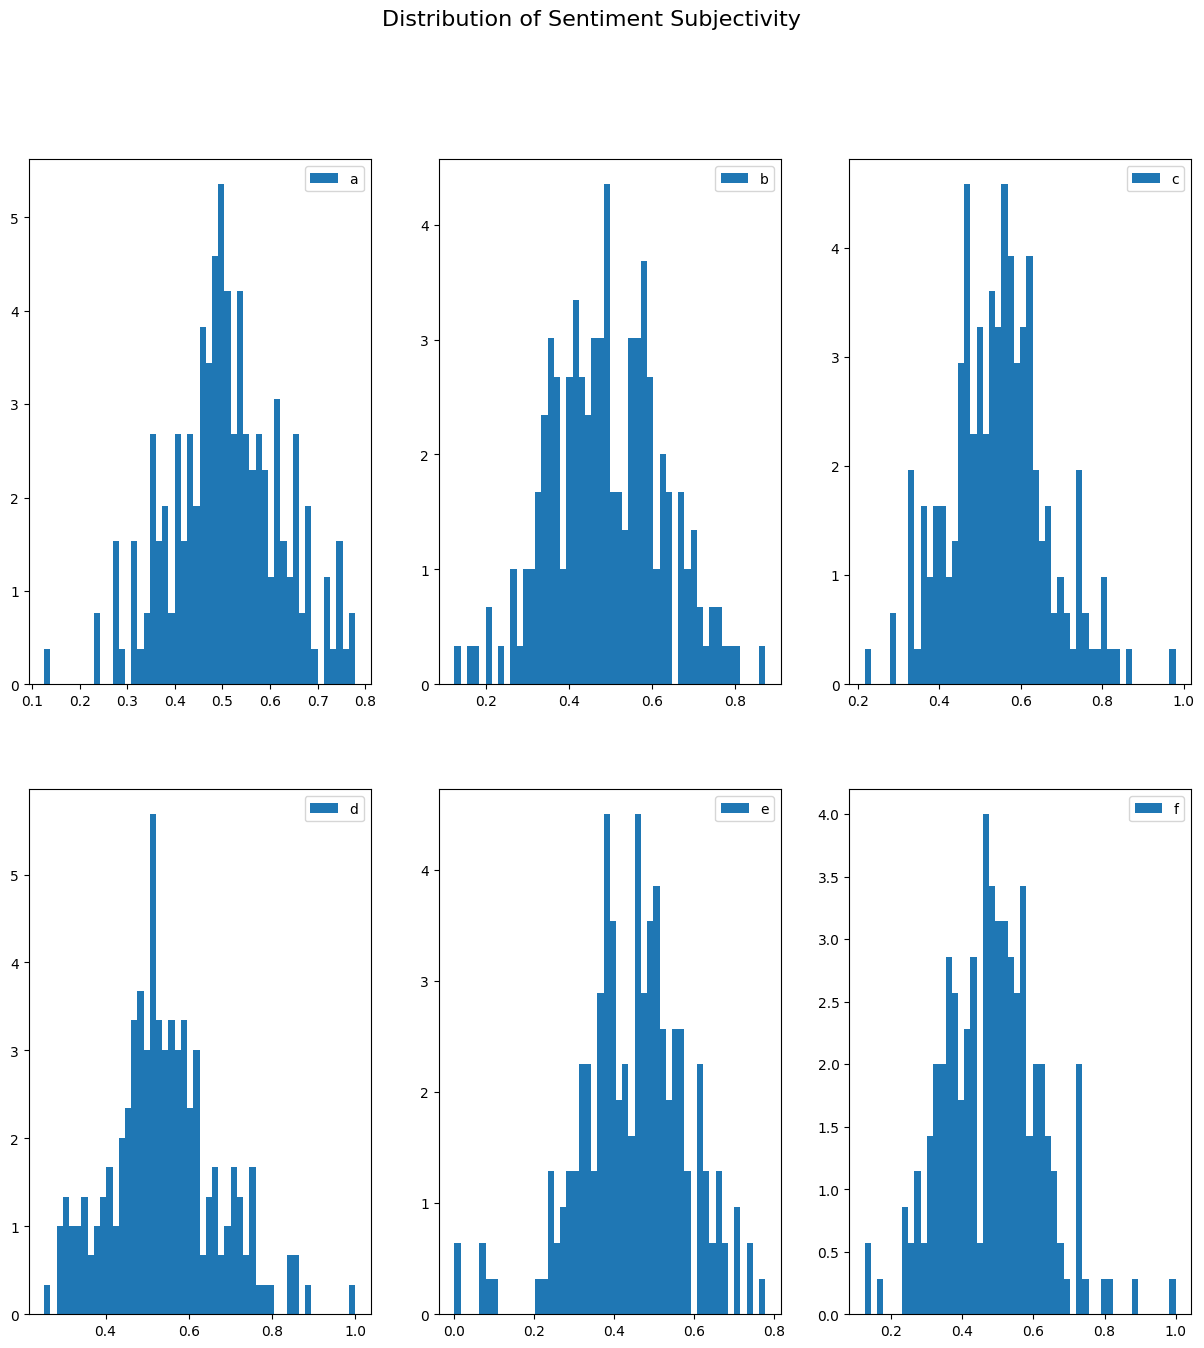

In [18]:
# Evaluation of Sentiment Subjectivity Feature using histograms:
# Distribution of Sentiment Subjectivity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Subjectivity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_subjectivity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Most Frequent Words in each book**

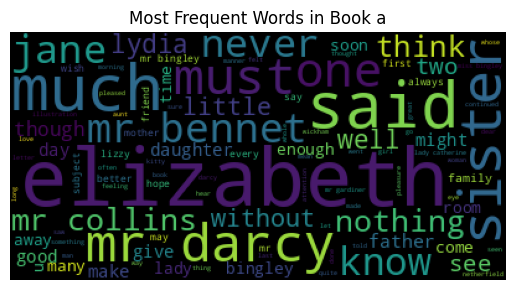

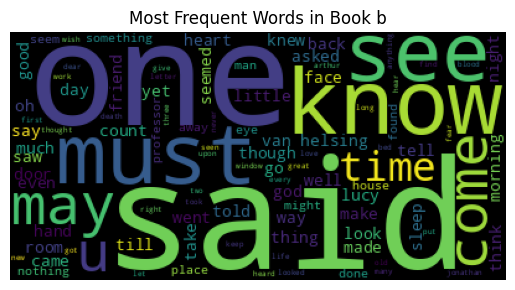

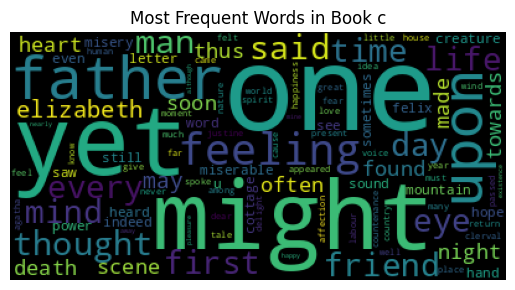

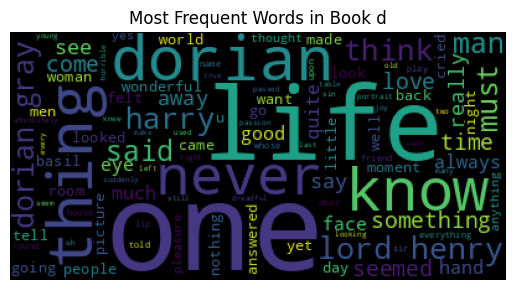

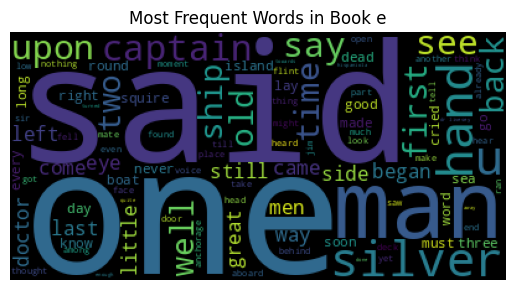

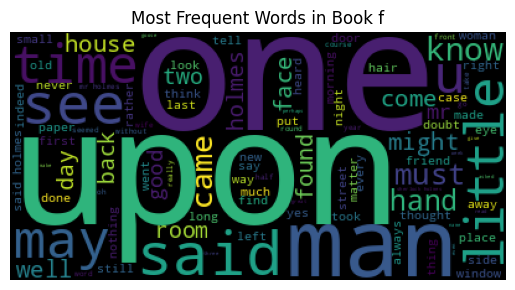

In [19]:
# Most frequent words in each book
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  corpus = ' '.join([word for doc in corpus for word in get_tokens(doc)])
  wc = wordcloud.WordCloud(background_color='black', max_words=100)
  wc = wc.generate(corpus)
  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title('Most Frequent Words in Book {}'.format(y))
  plt.imshow(wc, cmap=None)
  plt.show()

## **Most Frequent Unigrams and Bigrams in each book**

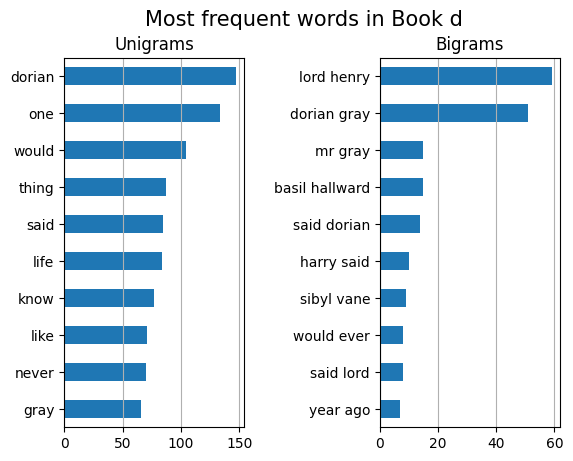

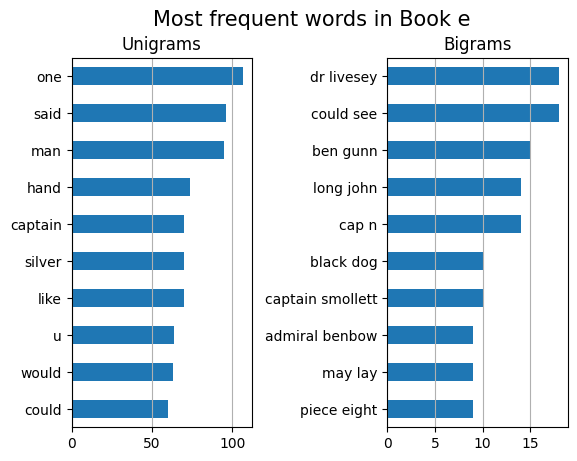

In [20]:
top= 10
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in Book {}".format(y), fontsize=15)
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0],legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.75)
  plt.show()

## **Top 10 collocations in each book**

In [21]:
def find_top_collocations(data,label):
  docs = data[data['Label']==label]['Partition_lemmatized']
  author_allwords = [word for doc in docs for word in get_tokens(doc)]

  bigram_measures = BigramAssocMeasures()
  finder = BigramCollocationFinder.from_words(author_allwords)
  finder.apply_freq_filter(3)
  top_collocations = finder.nbest(bigram_measures.pmi, 10) ## Top 10 frequency collocations
  return top_collocations

In [22]:
for y in data['Label'].unique():
  top_collocations= find_top_collocations(data,y)
  print('Top 10 collocations in Book {}: {}'.format(y,top_collocations))

Top 10 collocations in Book a: [('accusation', 'illfounded'), ('examined', 'irreproachable'), ('strictly', 'examined'), ('illfounded', 'formed'), ('merited', 'severest'), ('scruple', 'abusing'), ('copyright', '1894'), ('hold', 'tongue'), ('reproof', 'unpardonable'), ('severest', 'reproof')]
Top 10 collocations in Book b: [('joseph', 'ste'), ('nineteenth', 'century'), ('ste', 'mary'), ('st', 'joseph'), ('achaffin', 'ye'), ('briskly', 'ye'), ('ye', 'excoose'), ('lord', 'godalming'), ('hundred', 'year'), ('eternal', 'rest')]
Top 10 collocations in Book c: [('conclusion', 'unremitting'), ('talent', 'flourished'), ('unfolding', 'number'), ('barbarity', 'desolated'), ('chemical', 'instrument'), ('de', 'lacey'), ('fail', 'impress'), ('genius', 'talent'), ('necessary', 'completion'), ('ruined', 'castle')]
Top 10 collocations in Book d: [('casual', 'questioning'), ('flesh', 'tainted'), ('gum', 'east'), ('manufacture', 'distilling'), ('mystical', 'ambergris'), ('nostril', 'quivered'), ('odorous'

# **Feature Engineering: Transform the data**

Check for distributions that are skewed i.e. having a tail extending out with some outliers. A model might dig too much into this skewed tail and generate a model maybe that's a little bit biased, so it's important to transform features with such distributions.

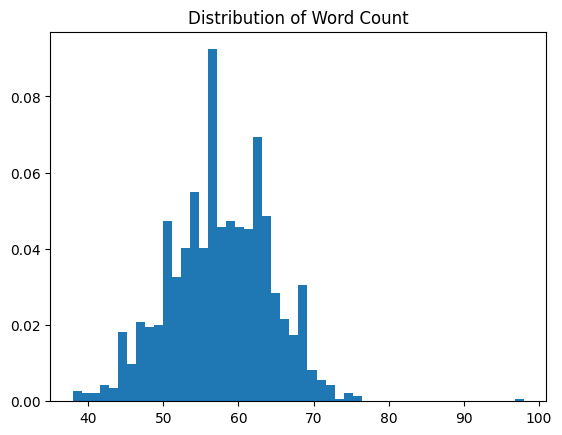

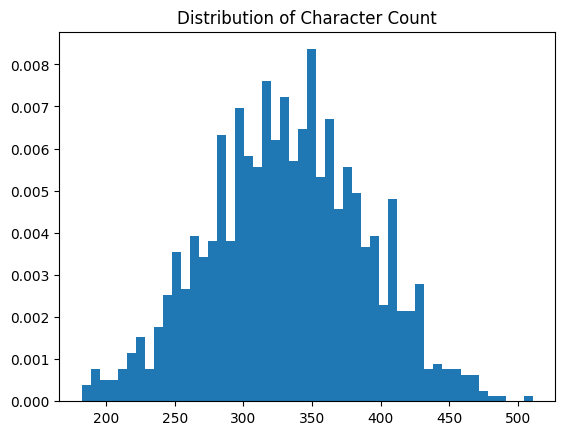

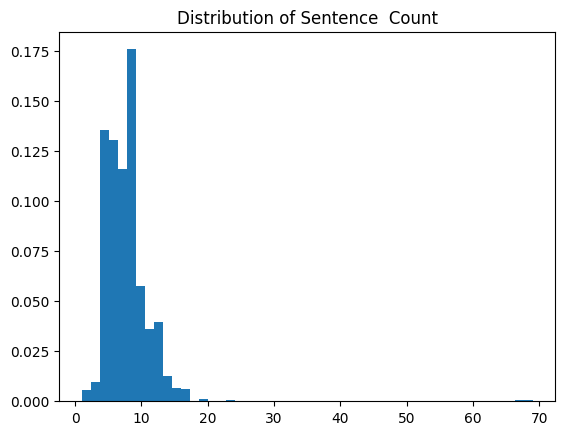

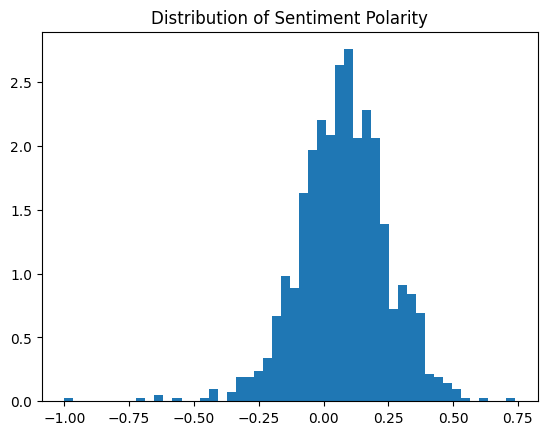

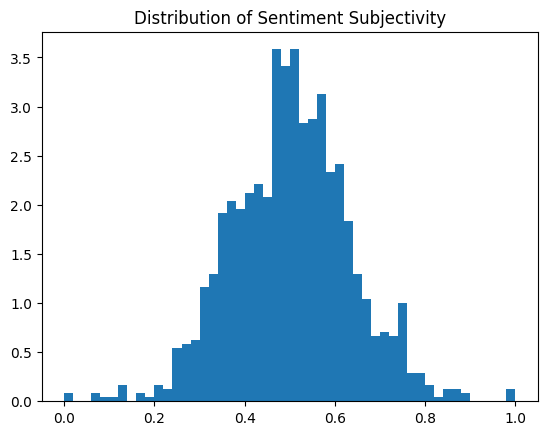

In [23]:
# Distribution of Word Count
plt.title('Distribution of Word Count')
plt.hist(data['Word_count'], bins=50, density=True)
plt.show()

# Distribution of Character Count
plt.title('Distribution of Character Count')
plt.hist(data['Character_count'], bins=50, density=True)
plt.show()

# Distribution of Sentence Count
plt.title('Distribution of Sentence  Count')
plt.hist(data['Sentence_count'], bins=50, density=True)
plt.show()

# Distribution of Average Word Length
plt.title('Distribution of Average Word Length')
plt.hist(data['Avg_word_length'], bins=50, density=True)
plt.show()

# Distribution of Average Sentence Length
plt.title('Distribution of Average Sentence Length')
plt.hist(data['Avg_sentence_length'], bins=50, density=True)
plt.show()

# Distribution of sentiment polarity
plt.title('Distribution of Sentiment Polarity')
plt.hist(data['Sentiment_polarity'], bins=50, density=True)
plt.show()

# Distribution of sentiment subjectivity
plt.title('Distribution of Sentiment Subjectivity')
plt.hist(data['Sentiment_subjectivity'], bins=50, density=True)
plt.show()

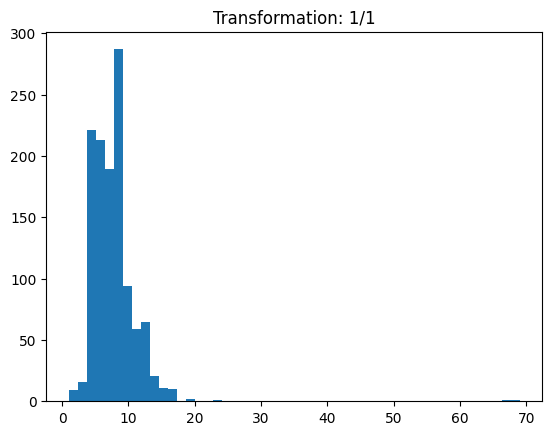

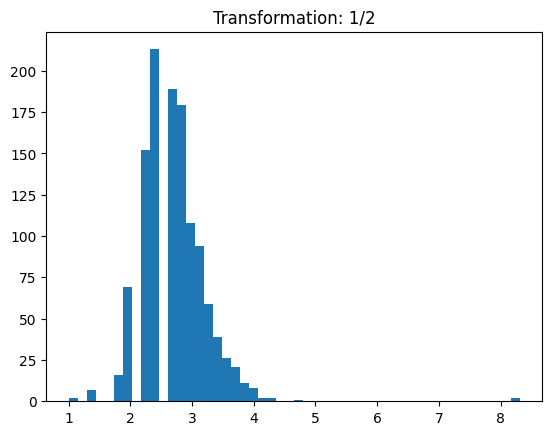

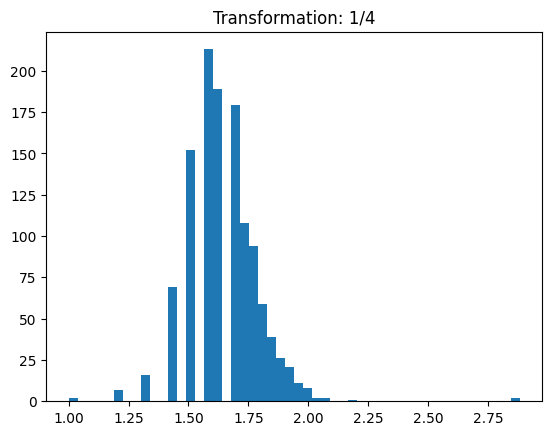

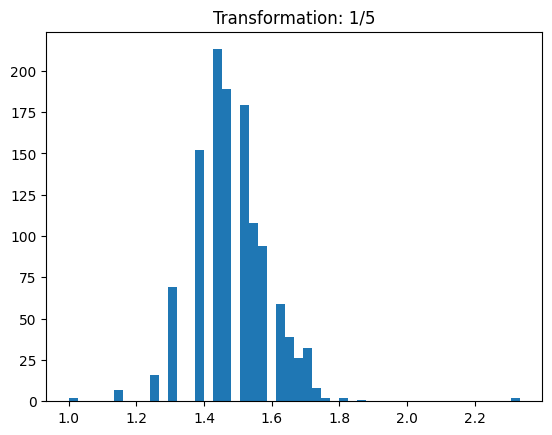

In [24]:
# Box-Cox Power Transformation of Sentence Count
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Sentence_count'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [25]:
data['Sentence_count']= data['Sentence_count']**(1/5)

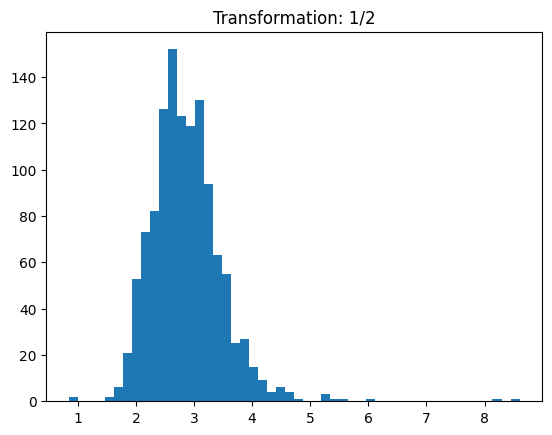

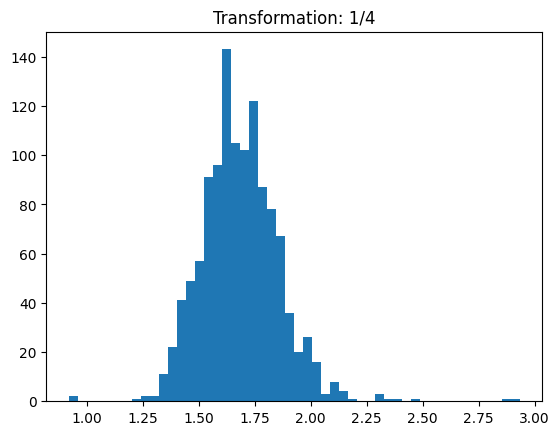

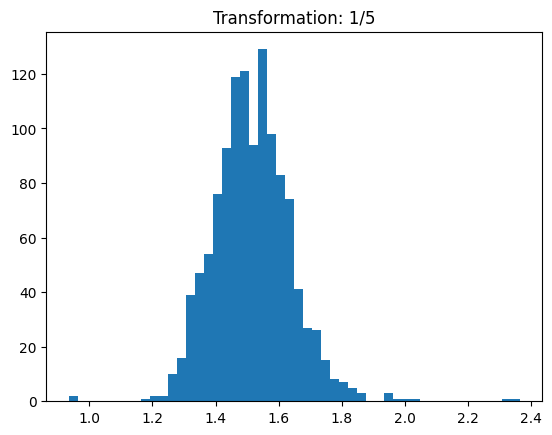

In [26]:
# Box-Cox Power Transformation of Average Sentence Length
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Avg_sentence_length'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [27]:
data['Avg_sentence_length']= data['Avg_sentence_length']**(1/5)

In [28]:
data

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
1                   Pride and Prejudice         Jane Austen     a   
2                   Pride and Prejudice         Jane Austen     a   
3                   Pride and Prejudice         Jane Austen     a   
4                   Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1195  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1196  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1198  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1199  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
1     of Mr. Bingley . They attacked him in various ...   
2     pleases. ” “ And if not able to please himself...   
3     a mile across the park . Every park has its be...   
4     visit ; and when she rose to take leave , Eliz...   
...                                                 ...   
1195  not tell what indirect or political influence ...   
1196  in Australia. ” “ What of the rat , then ? ” S...   
1197  , “ I say now , as I said then , that a man sh...   
1198  bite . I had no time to think of it. ” “ And h...   
1199  the lamp and examined it intently . I had left...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
1     mr bingley attack variou way barefac question ...   
2     pleas abl pleas arrang least great pleasur pow...   
3     mile across park everi park beauti prospect el...   
4     visit rose take leav elizabeth asham mother un...   
...                                                 ...   
1195  tell indirect polit influenc might brought bea...   
1196  australia rat sherlock holm took fold paper po...   
1197  say said man keep littl brainatt stock furnitu...   
1198  bite time think succeed well clue hollow hand ...   
1199  lamp examin intent left chair gaze shoulder en...   

                                   Partition_lemmatized  Word_count  \
0     library started back begging pardon protested ...          64   
1     mr bingley attacked various way barefaced ques...          66   
2     plea able please arrangement least great pleas...          52   
3     mile across park every park beauty prospect el...          72   
4     visit rose take leave elizabeth ashamed mother...          59   
...                                                 ...         ...   
1195  tell indirect political influence might brough...          47   
1196  australia rat sherlock holmes took folded pape...          45   
1197  say said man keep little brainattic stocked fu...          59   
1198  bite time think succeeded well clue hollow han...          52   
1199  lamp examined intently left chair gazing shoul...          49   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 358        1.551846         5.593750             1.480429   
1                 426        1.584893         6.454545             1.458508   
2                 298        1.615394         5.730769             1.364338   
3                 446        1.475773         6.194444             1.593848   
4                 358        1.551846         6.067797             1.456538   
...               ...             ...              ...                  ...   
1195              250        1.695218         5.319149             1.274072   
1196              246        1.718772         5.466667             1.245731   
1197              324        1.475773         5.491525             1.531619   
1198              278        1.695218         5.346154             1.300095   
1199              304        1.584893         6.204082      

# **Feature Engineering: Vectorization**

## **BOW/Count Vectorization**

In [29]:
# Instantiate CountVectorizer object and define parameters
BOW_vect= CountVectorizer()

# Fit CountVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
data_BOW= BOW_vect.fit_transform(data['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays into a data frame
data_BOW= pd.DataFrame(data_BOW.toarray())
data_BOW.columns= BOW_vect.get_feature_names_out()

In [30]:
data_BOW.shape

(1200, 9844)

In [31]:
data_BOW.head()

10  100  1000  105  11  1115  11th  12  12th  13  ...  youngster  your  \
0   0    0     0    0   0     0     0   0     0   0  ...          0     0   
1   0    0     0    0   0     0     0   0     0   0  ...          0     0   
2   0    0     0    0   0     0     0   0     0   0  ...          0     0   
3   0    0     0    0   0     0     0   0     0   0  ...          0     0   
4   0    0     0    0   0     0     0   0     0   0  ...          0     0   

   youth  yus  zeal  zeropoint  zest  zoöphagous  édition  émaux  
0      0    0     0          0     0           0        0      0  
1      0    0     0          0     0           0        0      0  
2      0    0     0          0     0           0        0      0  
3      0    0     0          0     0           0        0      0  
4      0    0     0          0     0           0        0      0  

[5 rows x 9844 columns]

In [32]:
# Words that BOW_vect learnt
BOW_vect.vocabulary_

{'library': 5096,
 'started': 8232,
 'back': 732,
 'begging': 849,
 'pardon': 6150,
 'protested': 6727,
 'never': 5785,
 'read': 6902,
 'novel': 5870,
 'kitty': 4922,
 'stared': 8226,
 'lydia': 5291,
 'exclaimed': 3110,
 'book': 1052,
 'produced': 6670,
 'deliberation': 2283,
 'chose': 1500,
 'fordyce': 3525,
 'sermon': 7661,
 'gaped': 3705,
 'opened': 5990,
 'volume': 9430,
 'monotonous': 5609,
 'solemnity': 8048,
 'three': 8783,
 'page': 6108,
 'interrupted': 4715,
 'know': 4936,
 'mamma': 5338,
 'uncle': 9122,
 'philip': 6332,
 'talk': 8616,
 'turning': 9053,
 'away': 715,
 'richard': 7253,
 'colonel': 1647,
 'forster': 3569,
 'hire': 4251,
 'aunt': 680,
 'told': 8862,
 'saturday': 7455,
 'shall': 7702,
 'walk': 9461,
 'meryton': 5493,
 'tomorrow': 8870,
 'hear': 4147,
 'ask': 592,
 'mr': 5675,
 'denny': 2309,
 'come': 1657,
 'town': 8909,
 'bid': 926,
 'two': 9078,
 'eldest': 2842,
 'sister': 7884,
 'hold': 4275,
 'tongue': 8874,
 'collins': 1646,
 'much': 5676,
 'bingley': 938,
 '

## **TF-IDF Vectorization**

In [33]:
# Instantiate TfidfVectorizer object and define parameters
tfidf_vect= TfidfVectorizer()

# Fit TfidfVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
data_tfidf= tfidf_vect.fit_transform(data['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays to a data frame
data_tfidf= pd.DataFrame(data_tfidf.toarray())
data_tfidf.columns= tfidf_vect.get_feature_names_out()

In [34]:
data_tfidf.shape

(1200, 9844)

In [35]:
data_tfidf.head()

10  100  1000  105   11  1115  11th   12  12th   13  ...  youngster  your  \
0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0   
1  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0   
2  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0   
3  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0   
4  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0   

   youth  yus  zeal  zeropoint  zest  zoöphagous  édition  émaux  
0    0.0  0.0   0.0        0.0   0.0         0.0      0.0    0.0  
1    0.0  0.0   0.0        0.0   0.0         0.0      0.0    0.0  
2    0.0  0.0   0.0        0.0   0.0         0.0      0.0    0.0  
3    0.0  0.0   0.0        0.0   0.0         0.0      0.0    0.0  
4    0.0  0.0   0.0        0.0   0.0         0.0      0.0    0.0  

[5 rows x 9844 columns]

In [36]:
# Words that tfidf_vect learnt
tfidf_vect.vocabulary_

{'library': 5096,
 'started': 8232,
 'back': 732,
 'begging': 849,
 'pardon': 6150,
 'protested': 6727,
 'never': 5785,
 'read': 6902,
 'novel': 5870,
 'kitty': 4922,
 'stared': 8226,
 'lydia': 5291,
 'exclaimed': 3110,
 'book': 1052,
 'produced': 6670,
 'deliberation': 2283,
 'chose': 1500,
 'fordyce': 3525,
 'sermon': 7661,
 'gaped': 3705,
 'opened': 5990,
 'volume': 9430,
 'monotonous': 5609,
 'solemnity': 8048,
 'three': 8783,
 'page': 6108,
 'interrupted': 4715,
 'know': 4936,
 'mamma': 5338,
 'uncle': 9122,
 'philip': 6332,
 'talk': 8616,
 'turning': 9053,
 'away': 715,
 'richard': 7253,
 'colonel': 1647,
 'forster': 3569,
 'hire': 4251,
 'aunt': 680,
 'told': 8862,
 'saturday': 7455,
 'shall': 7702,
 'walk': 9461,
 'meryton': 5493,
 'tomorrow': 8870,
 'hear': 4147,
 'ask': 592,
 'mr': 5675,
 'denny': 2309,
 'come': 1657,
 'town': 8909,
 'bid': 926,
 'two': 9078,
 'eldest': 2842,
 'sister': 7884,
 'hold': 4275,
 'tongue': 8874,
 'collins': 1646,
 'much': 5676,
 'bingley': 938,
 '

## **doc2vec Vectorization**

doc2vec requires you to create tagged documents. This tagged document, expects a list of words and a tag for each document. And then the doc2vec model trains on top of those tagged documents. There are numerous ways you can assign the tag. One common way is just to use the index as the tag.


In [37]:
# Create tagged document objects for each partition
docs= data['Partition_lemmatized'].apply(lambda x: get_tokens(x))
tagged_data= [TaggedDocument(words= doc, tags=[str(i)]) for i, doc in enumerate(docs)]

In [38]:
# Train a basic doc2vec model
d2v_vect= Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20, alpha=0.025, min_alpha=0.025)
d2v_vect.build_vocab(tagged_data)
d2v_vect.train(tagged_data, total_examples=d2v_vect.corpus_count, epochs=d2v_vect.epochs)

In [39]:
# Infer the vectors to be used in training and testing
data_d2v= pd.DataFrame(np.array([d2v_vect.infer_vector(doc.words) for doc in tagged_data]))

In [40]:
data_d2v

0         1         2         3         4         5         6   \
0     0.162236  0.197835 -0.802040  0.607237 -0.456579 -0.630131  0.575609   
1     0.785240  0.085046 -0.389699 -0.400790  0.126704  0.652528  0.442176   
2     0.433805  1.398520  0.808442 -0.233539  0.730348 -0.060202  0.966864   
3     0.178903  1.611672 -0.270347 -0.047152  0.699397 -0.199835  0.799367   
4    -0.006681 -0.388472 -0.562288 -0.032097  0.612105 -1.029842  0.861860   
...        ...       ...       ...       ...       ...       ...       ...   
1195 -0.450412  0.068415  0.039518  0.326282  0.399279 -1.148942  1.159455   
1196 -0.884902  0.181297 -0.062232  0.105275 -0.238122 -1.093294  0.256462   
1197  0.503046  1.404081  0.279078  0.427969  0.174241 -1.012741  0.475245   
1198  0.056902  1.275456  0.488924 -0.901065  0.551142 -0.996668  0.439615   
1199 -0.483034  0.140400  0.158544 -0.283526 -0.257740 -0.341277  0.574840   

            7         8         9   ...        90        91        92  \
0     0.936161 -1.104882 -0.273028  ...  0.493757  0.196080  0.075298   
1     0.875354 -0.271746  0.203265  ...  0.099593  0.538952  1.065332   
2     0.404957 -1.121616 -0.238516  ...  0.318264  0.425172  0.028504   
3     1.811767 -0.704506 -1.558274  ...  0.112741 -0.250380 -0.561672   
4     1.318832  0.065224 -1.345528  ... -0.552411  0.536315  0.411844   
...        ...       ...       ...  ...       ...       ...       ...   
1195  1.557234  0.137325 -0.866736  ...  0.253742 -0.048652  0.578066   
1196  1.148239 -1.637479  0.125169  ...  0.146404  0.254423 -0.108886   
1197  0.946384 -0.240717  0.124137  ...  0.502798  1.080130  0.876761   
1198  0.722345 -0.303126 -0.244753  ... -0.178695  0.545009 -0.032053   
1199  0.902943 -0.386113  0.621387  ...  0.459283 -0.023510  0.531657   

            93        94        95        96        97        98        99  
0     0.022122  1.312014 -0.182562  0.509380 -0.075366 -0.104094  0.520749  
1     0.240713  0.604761 -0.211071  0.074936 -0.085375 -0.492691  0.927134  
2    -0.043235  0.155822 -0.460573 -0.007235 -0.686494  0.385528  0.675341  
3    -0.272471  0.382771  0.416355  0.429744 -0.868016 -0.451979  0.717528  
4    -1.188322 -0.055838  0.037692 -0.292698 -0.984950 -1.467718  1.227210  
...        ...       ...       ...       ...       ...       ...       ...  
1195  0.233431  0.891369  0.070229 -0.140306 -0.276331  0.171813 -0.478171  
1196 -0.108268  0.968962  0.437088  0.767717 -0.574098  0.959198 -0.090611  
1197  0.173337  0.023024  0.342528  0.491493  0.551362  0.043983 -0.199155  
1198 -0.098386  0.581137  1.194147  1.040471  0.438122 -0.554280 -0.359953  
1199  0.701647  1.048832  0.994925  0.333860 -0.090117 -0.116236 -0.973579  

[1200 rows x 100 columns]

## **LDA Vectorization**

In [41]:
# Convert the 'Partition_lemmatized' column of the 'data' DataFrame into a list of tokenized documents to use for LDA
docs= list(data['Partition_lemmatized'].apply(lambda x: get_tokens(x)))

# Compute bigrams.

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [42]:
# Train LDA model.

# Set training parameters.
num_topics = 6  # Number of topics to extract from the corpus.
chunksize = 2000  # Number of documents to be used in each training chunk.
passes = 20  # Number of passes through the corpus during training.
iterations = 400  # Maximum number of iterations through the corpus when training the model.
eval_every = None  # Do not evaluate model perplexity during training (to save time).

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token  # Create a mapping from word IDs to words.

# Train the LDA model.
lda_model = LdaModel(
    corpus=corpus,  # Bag-of-words representation of the corpus.
    id2word=id2word,  # Mapping from word IDs to words.
    chunksize=chunksize,  # Number of documents to be used in each training chunk.
    alpha='auto',  # Automatically learn the document-topic distribution.
    eta='auto',  # Automatically learn the topic-word distribution.
    iterations=iterations,  # Maximum number of iterations through the corpus.
    num_topics=num_topics,  # Number of topics to extract from the corpus.
    passes=passes,  # Number of passes through the corpus during training.
    eval_every=eval_every  # Frequency of evaluating model perplexity during training.
)

In [43]:
# Print topics generated by the trained LDA model
for idx, topic in lda_model.print_topics():
    print("Topic {}:".format(idx))
    print(topic) # Print the words and their corresponding probabilities in the topic.
    print()

Topic 0:
0.011*"said" + 0.010*"one" + 0.010*"dorian" + 0.009*"would" + 0.008*"like" + 0.007*"know" + 0.007*"thing" + 0.006*"time" + 0.006*"thought" + 0.006*"could"

Topic 1:
0.008*"must" + 0.007*"upon" + 0.005*"day" + 0.005*"came" + 0.005*"know" + 0.004*"would" + 0.004*"could" + 0.004*"every" + 0.004*"jonathan" + 0.004*"come"

Topic 2:
0.012*"one" + 0.011*"said" + 0.008*"see" + 0.008*"would" + 0.008*"man" + 0.008*"could" + 0.008*"hand" + 0.007*"u" + 0.006*"back" + 0.006*"door"

Topic 3:
0.022*"mr" + 0.011*"said" + 0.010*"elizabeth" + 0.010*"could" + 0.009*"would" + 0.008*"much" + 0.007*"one" + 0.007*"know" + 0.007*"must" + 0.007*"lady"

Topic 4:
0.011*"would" + 0.009*"day" + 0.008*"man" + 0.008*"one" + 0.007*"could" + 0.006*"made" + 0.005*"found" + 0.005*"however" + 0.005*"every" + 0.005*"time"

Topic 5:
0.011*"one" + 0.008*"man" + 0.007*"could" + 0.007*"might" + 0.006*"time" + 0.006*"may" + 0.006*"friend" + 0.005*"father" + 0.005*"upon" + 0.005*"would"



In [44]:
top_topics = lda_model.top_topics(corpus, texts=docs, dictionary=dictionary)

print('Individual Topic Coherences:')
for i in range(num_topics):
  print('Topic{}: {}'.format(i,top_topics[i][1]))

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('\nAverage topic coherence: {}'.format(avg_topic_coherence))

Individual Topic Coherences:
Topic0: -1.8081720833629444
Topic1: -1.9480159518807616
Topic2: -2.0161126150860706
Topic3: -2.10151257877942
Topic4: -2.649568060419739
Topic5: -2.8095307910196587

Average topic coherence: -2.222152013424766


In [45]:
# Initialize an empty list to store the dense vectors representing topic distributions for each document.
data_lda=[]

# Iterate over each document in the tokenized document list.
for i in range(len(docs)):
  # Get the topic distribution for the ith document
  lda_vector= lda_model[dictionary.doc2bow(docs[i])]

  # Convert the topic distribution to a dense vector
  dense_vector = gensim.matutils.sparse2full(lda_vector,lda_model.num_topics)

  # Append the dense vector representation of the topic distribution to the data_lda list.
  data_lda.append(dense_vector)

# Convert the list of dense vectors to a pandas DataFrame.
data_lda= pd.DataFrame(data_lda)

In [46]:
data_lda

0    1         2         3    4         5
0     0.000000  0.0  0.000000  0.995563  0.0  0.000000
1     0.000000  0.0  0.000000  0.995884  0.0  0.000000
2     0.000000  0.0  0.000000  0.994976  0.0  0.000000
3     0.000000  0.0  0.000000  0.996404  0.0  0.000000
4     0.000000  0.0  0.000000  0.995730  0.0  0.000000
...        ...  ...       ...       ...  ...       ...
1195  0.000000  0.0  0.868406  0.000000  0.0  0.127543
1196  0.000000  0.0  0.636050  0.000000  0.0  0.359169
1197  0.385571  0.0  0.000000  0.610340  0.0  0.000000
1198  0.000000  0.0  0.309358  0.000000  0.0  0.686132
1199  0.531387  0.0  0.000000  0.463795  0.0  0.000000

[1200 rows x 6 columns]

In [47]:
#vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
#vis

# **Clustering**

Methods:
1. KMeans Clustering
2. Hierarchical Clustering
3. EM Clustering

Evaluation:
1. Silhouette Score
2. Cohen Kappa
3. Coherence

In [48]:
# Functions to reduce dimensionality (will be used for visualizations)
def get_TSNE(data):
  tsne = TSNE(n_components=2, random_state=42)
  data_tsne = tsne.fit_transform(data)
  return data_tsne

In [49]:
# Function to calculate silhouette score
def calculate_silhouette(data,cluster_labels):
  ss= silhouette_score(data,cluster_labels,random_state=42)
  return ss

In [50]:
# Function to get the majority author label (ground truth) that a cluster label corresponds to
def get_cluster_to_majority_author(y, cluster_labels):
    # Compute counts of data points belonging to both clusters and class labels
    num_classes = len(y.unique())
    cluster_counts = np.zeros((len(np.unique(cluster_labels)), num_classes), dtype=int)
    for cluster in range(len(np.unique(cluster_labels))):
        indices = np.where(cluster_labels == cluster)[0]
        author_labels = y.iloc[indices]
        for i, author in enumerate(y.unique()):
          cluster_counts[cluster,i] = np.sum(author_labels== author)

    # Solve the assignment problem to find the optimal mapping
    row_indices, col_indices = linear_sum_assignment(-cluster_counts)  # Minimizing negative counts
    optimal_assignment = dict(zip(row_indices, col_indices))

    # Assign labels based on the optimal assignment
    cluster_to_majority_author = {}
    for cluster, assigned_class in optimal_assignment.items():
        cluster_to_majority_author[cluster] = y.unique()[assigned_class]
    return cluster_to_majority_author

In [51]:
# Function to calculate cohen kappa
def calculate_kappa_score(y, cluster_labels):
    cluster_to_majority_author= get_cluster_to_majority_author(y,cluster_labels)
    y_pred = [cluster_to_majority_author[label] for label in cluster_labels]
    kappa = cohen_kappa_score(y, y_pred)
    return kappa

In [52]:
# Function to evaluate individual cluster coherence
def compute_cluster_coherence(cluster_labels,cluster):
  docs= list(data[cluster_labels==cluster]['Partition_lemmatized'].apply(lambda x: get_tokens(x)))
  # Compute bigrams.

  # Add bigrams to docs (only ones that appear 20 times or more).
  bigram = Phrases(docs, min_count=20)
  for idx in range(len(docs)):
      for token in bigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)

  # Remove rare and common tokens.

  # Create a dictionary representation of the documents.
  dictionary = Dictionary(docs)

  # Filter out words that occur less than 20 documents, or more than 50% of the documents.
  #dictionary.filter_extremes(no_below=2, no_above=0.5)

  # Bag-of-words representation of the documents.
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Train LDA model.

  # Set training parameters.
  num_topics = 6  # Number of topics to extract from the corpus.
  chunksize = 2000  # Number of documents to be used in each training chunk.
  passes = 20  # Number of passes through the corpus during training.
  iterations = 400  # Maximum number of iterations through the corpus when training the model.
  eval_every = None  # Do not evaluate model perplexity during training (to save time).

  # Make an index to word dictionary.
  temp = dictionary[0]  # This is only to "load" the dictionary.
  id2word = dictionary.id2token  # Create a mapping from word IDs to words.

  # Train the LDA model.
  lda_model = LdaModel(
      corpus=corpus,  # Bag-of-words representation of the corpus.
      id2word=id2word,  # Mapping from word IDs to words.
      chunksize=chunksize,  # Number of documents to be used in each training chunk.
      alpha='auto',  # Automatically learn the document-topic distribution.
      eta='auto',  # Automatically learn the topic-word distribution.
      iterations=iterations,  # Maximum number of iterations through the corpus.
      num_topics=num_topics,  # Number of topics to extract from the corpus.
      passes=passes,  # Number of passes through the corpus during training.
      eval_every=eval_every  # Frequency of evaluating model perplexity during training.
  )

  top_topics = lda_model.top_topics(corpus, texts=docs, dictionary=dictionary)
  coherence = sum([t[1] for t in top_topics]) / num_topics
  return coherence

# Function to evaluate average cluster coherence
def compute_average_cluster_coherence(cluster_labels):
  S=0
  for cluster in np.unique(cluster_labels):
    coherence= compute_cluster_coherence(cluster_labels,cluster)
    S+= coherence
  return S/len(np.unique(cluster_labels))

In [53]:
# Function to evaluate clustering method
def evaluate_clusterer(data,y,cluster_labels):
  silhouette= calculate_silhouette(data,cluster_labels)
  kappa= calculate_kappa_score(y,cluster_labels)
  coherence= compute_average_cluster_coherence(cluster_labels)
  metrics = pd.DataFrame({'Silhouette': [silhouette], 'Kappa': [kappa], 'Coherence': [coherence]})
  return metrics

In [54]:
# Function to plot 2D data as per label
def plotData(X2D,y,labels,cluster_to_majority_author=None):
    colors = {'a':'red','b':'yellow','c':'green','d':'blue','e':'orange','f':'brown'}
    plt.figure(figsize=(8, 6))
    plt.xlabel('X1')
    plt.ylabel('X2')
    for K in range(len(labels)):
          if cluster_to_majority_author:
            plt.scatter(X2D[y == labels[K],0], X2D[y == labels[K],1], c=colors[cluster_to_majority_author[labels[K]]], label=str(labels[K])+'->'+cluster_to_majority_author[labels[K]])
          else:
            plt.scatter(X2D[y == labels[K],0], X2D[y == labels[K],1], c=colors[labels[K]], label=labels[K])
    plt.legend(title='Labels')

## **KMeans**

In [55]:
def perform_kmeans(data, n_clusters=6):
    kmeans = KMeans(n_clusters=6, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans.cluster_centers_

### **KMeans with BOW**

In [56]:
kmeans_BOW_cluster_labels,kmeans_BOW_cluster_centers= perform_kmeans(data_BOW,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [57]:
# Evaluate metrics
kmeans_BOW_metrics= evaluate_clusterer(data_BOW,data['Label'],kmeans_BOW_cluster_labels)
kmeans_BOW_metrics

Silhouette  Kappa  Coherence
0     0.00471  0.226  -3.153903

In [58]:
# Check which majority authors the cluster labels correspond to
kmeans_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_BOW_cluster_labels)
kmeans_BOW_cluster_to_majority_author

{0: 'f', 1: 'd', 2: 'a', 3: 'c', 4: 'e', 5: 'b'}

In [59]:
# Transform data to 2D tsne to plot
data_BOW_tsne= get_TSNE(data_BOW)

Text(0.5, 1.0, 'BOW Data labeled with KMeans')

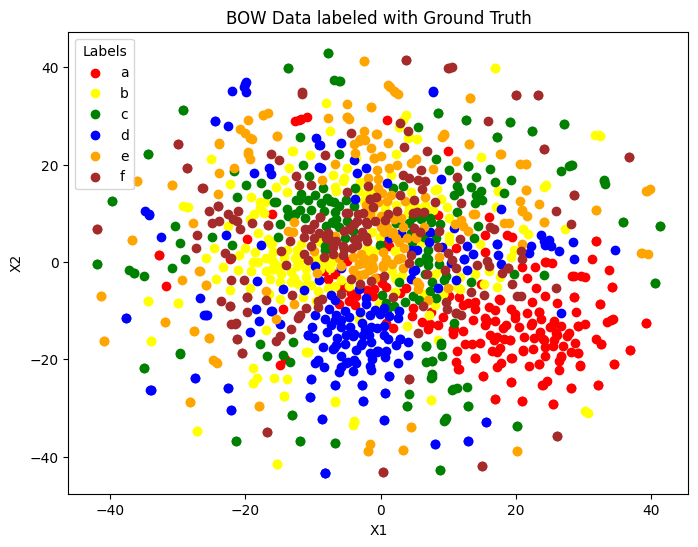

In [60]:
# Plot
plotData(data_BOW_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_tsne,kmeans_BOW_cluster_labels,np.unique(kmeans_BOW_cluster_labels),kmeans_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with KMeans')

### **KMeans with TFIDF**

In [61]:
kmeans_tfidf_cluster_labels,kmeans_tfidf_cluster_centers= perform_kmeans(data_tfidf,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
# Evaluate metrics
kmeans_tfidf_metrics= evaluate_clusterer(data_tfidf,data['Label'],kmeans_tfidf_cluster_labels)
kmeans_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.005352  0.631  -2.221145

In [63]:
# Check which majority authors the cluster labels correspond to
kmeans_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_tfidf_cluster_labels)
kmeans_tfidf_cluster_to_majority_author

{0: 'b', 1: 'd', 2: 'a', 3: 'c', 4: 'f', 5: 'e'}

In [64]:
# Transform data to 2D tsne to plot
data_tfidf_tsne= get_TSNE(data_tfidf)

Text(0.5, 1.0, 'tfidf Data labeled with KMeans')

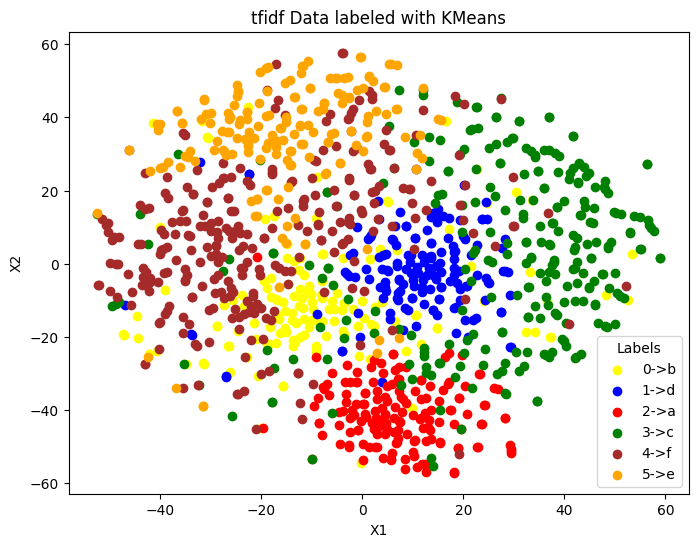

In [65]:
# Plot
plotData(data_tfidf_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_tsne,kmeans_tfidf_cluster_labels,np.unique(kmeans_tfidf_cluster_labels),kmeans_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with KMeans')

### **KMeans with doc2vec**

In [66]:
kmeans_d2v_cluster_labels,kmeans_d2v_cluster_centers= perform_kmeans(data_d2v,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
# Evaluate metrics
kmeans_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],kmeans_d2v_cluster_labels)
kmeans_d2v_metrics

Silhouette  Kappa  Coherence
0    0.043722  0.774  -2.215274

In [68]:
# Check which majority authors the cluster labels correspond to
kmeans_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_d2v_cluster_labels)
kmeans_d2v_cluster_to_majority_author

{0: 'b', 1: 'd', 2: 'a', 3: 'e', 4: 'c', 5: 'f'}

In [69]:
# Transform data to 2D tsne to plot
data_d2v_tsne= get_TSNE(data_d2v)

Text(0.5, 1.0, 'd2v Data labeled with KMeans')

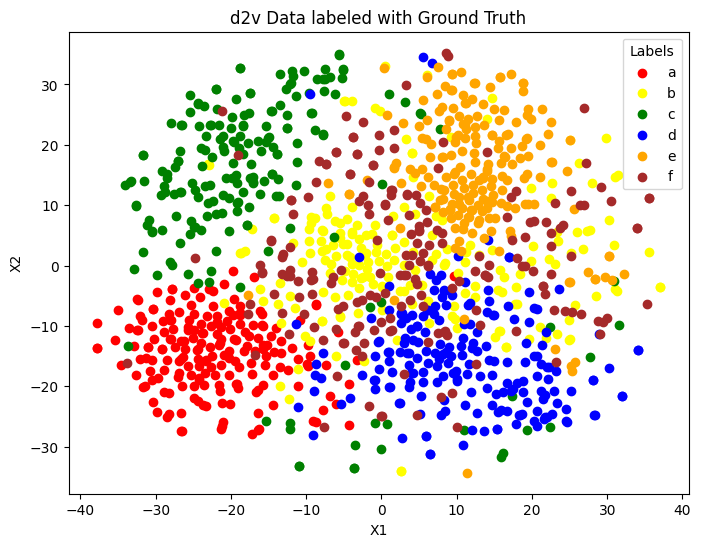

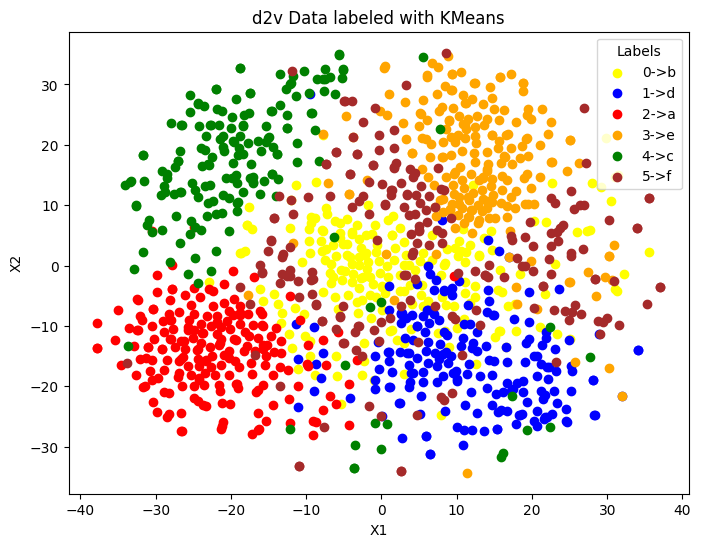

In [70]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,kmeans_d2v_cluster_labels,np.unique(kmeans_d2v_cluster_labels),kmeans_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with KMeans')

### **KMeans with LDA**

In [71]:
kmeans_lda_cluster_labels,kmeans_lda_cluster_centers= perform_kmeans(data_lda,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
# Evaluate metrics
kmeans_lda_metrics= evaluate_clusterer(data_lda,data['Label'],kmeans_lda_cluster_labels)
kmeans_lda_metrics

Silhouette  Kappa  Coherence
0    0.607482  0.366  -4.433112

In [73]:
# Check which majority authors the cluster labels correspond to
kmeans_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_lda_cluster_labels)
kmeans_lda_cluster_to_majority_author

{0: 'f', 1: 'e', 2: 'a', 3: 'c', 4: 'd', 5: 'b'}

In [74]:
# Transform data to 2D tsne to plot
data_lda_tsne= get_TSNE(data_lda)

Text(0.5, 1.0, 'lda Data labeled with KMeans')

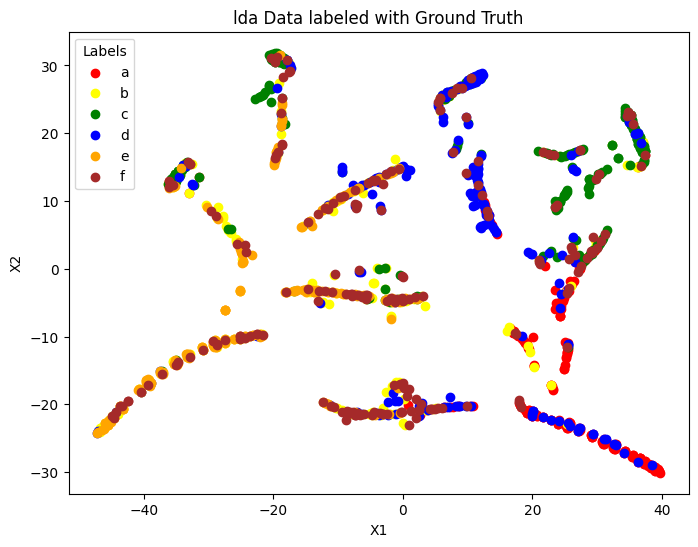

In [75]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,kmeans_lda_cluster_labels,np.unique(kmeans_lda_cluster_labels),kmeans_lda_cluster_to_majority_author)
plt.title('lda Data labeled with KMeans')

### **KMeans Metrics**

In [76]:
kmeans_metrics = pd.concat([kmeans_BOW_metrics,kmeans_tfidf_metrics,kmeans_d2v_metrics,kmeans_lda_metrics]).reset_index(drop=True)
kmeans_metrics.index=['BOW','TFIDF','doc2vec','LDA']
kmeans_metrics

Silhouette  Kappa  Coherence
BOW        0.004710  0.226  -3.153903
TFIDF      0.005352  0.631  -2.221145
doc2vec    0.043722  0.774  -2.215274
LDA        0.607482  0.366  -4.433112

## **Hierarchical Clustering**

### **Hierarchical Clustering with BOW**

In [77]:
def perform_hc(data, n_clusters=6):
  hc = AgglomerativeClustering(n_clusters = 6, metric = 'euclidean', linkage = 'ward')
  cluster_labels = hc.fit_predict(data)
  return cluster_labels

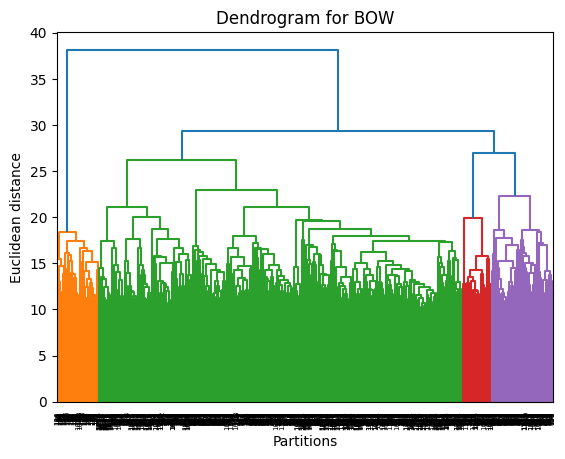

In [78]:
dendrogrm = sch.dendrogram(sch.linkage(data_BOW, method = 'ward'))
plt.title('Dendrogram for BOW')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [79]:
hc_BOW_cluster_labels= perform_hc(data_BOW,6)

In [80]:
# Evaluate metrics
hc_BOW_metrics= evaluate_clusterer(data_BOW,data['Label'],hc_BOW_cluster_labels)
hc_BOW_metrics

Silhouette  Kappa  Coherence
0    0.001546  0.336  -3.225656

In [81]:
# Check which majority authors the cluster labels correspond to
hc_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_BOW_cluster_labels)
hc_BOW_cluster_to_majority_author

{0: 'd', 1: 'b', 2: 'c', 3: 'a', 4: 'f', 5: 'e'}

Text(0.5, 1.0, 'BOW Data labeled with Hierarchical Clustering')

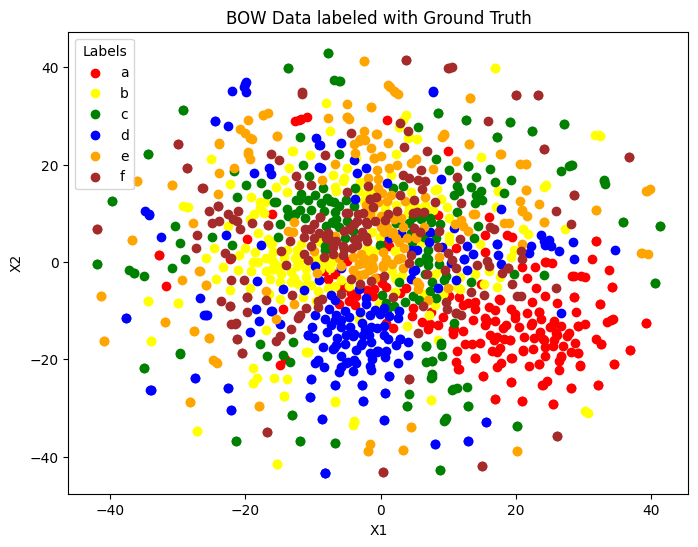

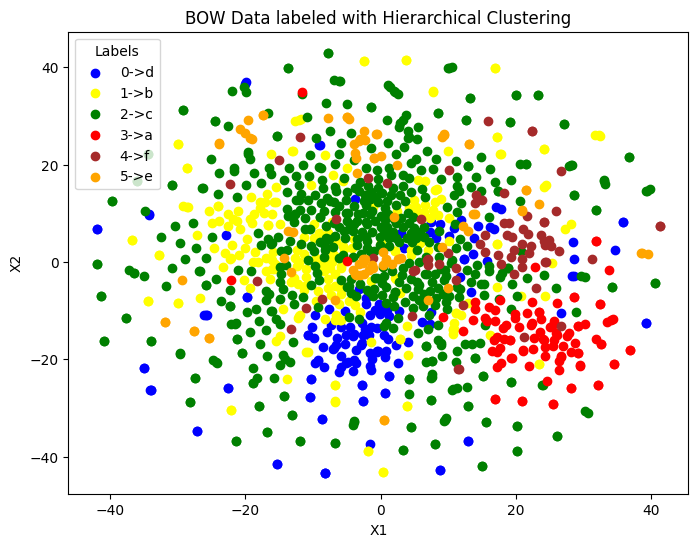

In [82]:
# Plot
plotData(data_BOW_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_tsne,hc_BOW_cluster_labels,np.unique(hc_BOW_cluster_labels),hc_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with tfidf**

In [83]:
dendrogrm = sch.dendrogram(sch.linkage(data_tfidf, method = 'ward'))
plt.title('Dendrogram for TFIDF')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [84]:
hc_tfidf_cluster_labels= perform_hc(data_tfidf,6)

In [85]:
# Evaluate metrics
hc_tfidf_metrics= evaluate_clusterer(data_tfidf,data['Label'],hc_tfidf_cluster_labels)
hc_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.003985  0.545  -1.959005

In [86]:
# Check which majority authors the cluster labels correspond to
hc_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_tfidf_cluster_labels)
hc_tfidf_cluster_to_majority_author

{0: 'e', 1: 'c', 2: 'd', 3: 'a', 4: 'f', 5: 'b'}

In [87]:
# Plot
plotData(data_tfidf_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_tsne,hc_tfidf_cluster_labels,np.unique(hc_tfidf_cluster_labels),hc_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with Hierarchical Clustering')

Text(0.5, 1.0, 'tfidf Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with doc2vec**

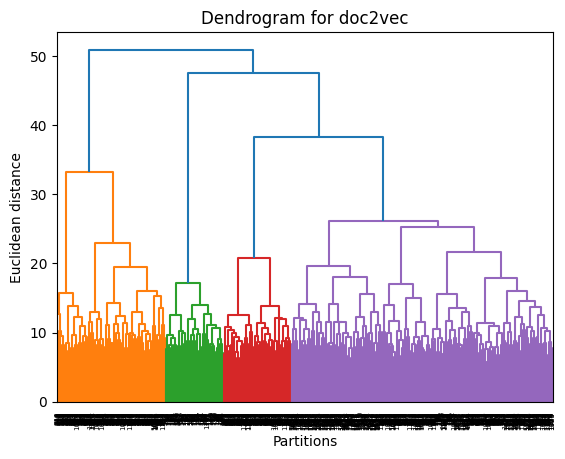

In [88]:
dendrogrm = sch.dendrogram(sch.linkage(data_d2v, method = 'ward'))
plt.title('Dendrogram for doc2vec')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [89]:
hc_d2v_cluster_labels= perform_hc(data_d2v,6)

In [90]:
# Evaluate metrics
hc_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],hc_d2v_cluster_labels)
hc_d2v_metrics

Silhouette  Kappa  Coherence
0     0.02583  0.526  -2.862588

In [91]:
# Check which majority authors the cluster labels correspond to
hc_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_d2v_cluster_labels)
hc_d2v_cluster_to_majority_author

{0: 'b', 1: 'c', 2: 'f', 3: 'e', 4: 'd', 5: 'a'}

Text(0.5, 1.0, 'd2v Data labeled with Hierarchical Clustering')

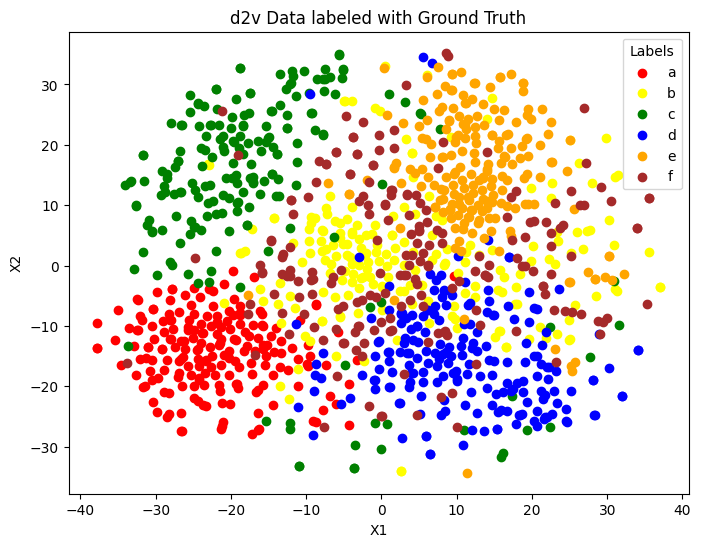

In [92]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,hc_d2v_cluster_labels,np.unique(hc_d2v_cluster_labels),hc_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with lda**

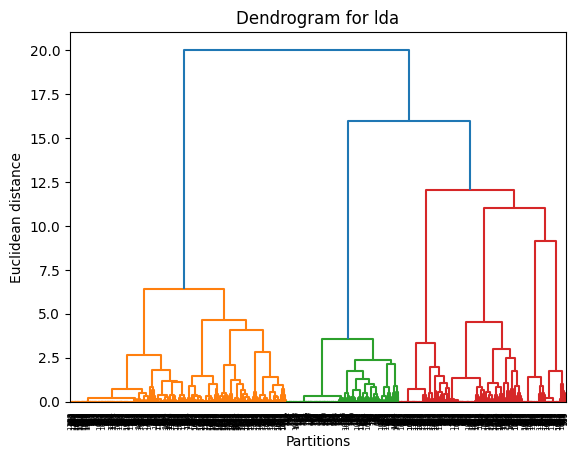

In [93]:
dendrogrm = sch.dendrogram(sch.linkage(data_lda, method = 'ward'))
plt.title('Dendrogram for lda')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [94]:
hc_lda_cluster_labels= perform_hc(data_lda,6)

In [95]:
# Evaluate metrics
hc_lda_metrics= evaluate_clusterer(data_lda,data['Label'],hc_lda_cluster_labels)
hc_lda_metrics

Silhouette  Kappa  Coherence
0    0.578091  0.365  -5.000248

In [96]:
# Check which majority authors the cluster labels correspond to
hc_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_lda_cluster_labels)
hc_lda_cluster_to_majority_author

{0: 'e', 1: 'c', 2: 'a', 3: 'd', 4: 'f', 5: 'b'}

Text(0.5, 1.0, 'lda Data labeled with Hierarchical Clustering')

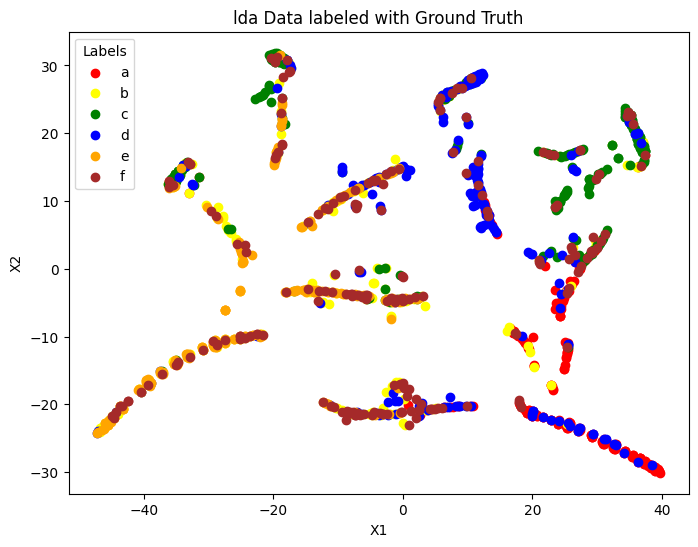

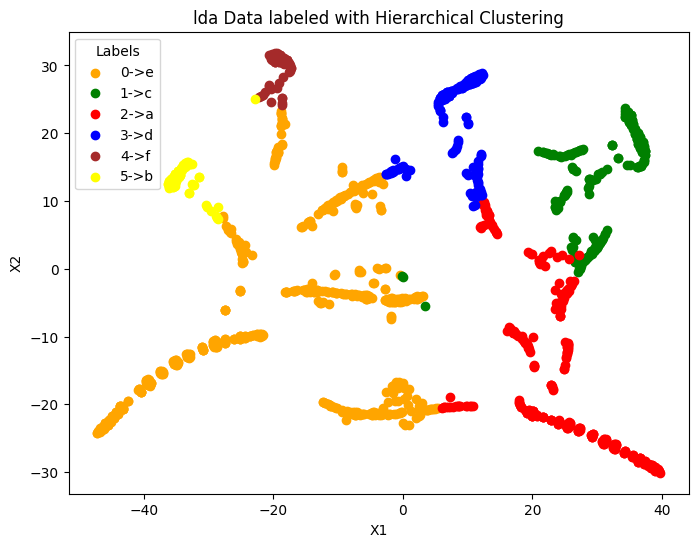

In [97]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,hc_lda_cluster_labels,np.unique(hc_lda_cluster_labels),hc_lda_cluster_to_majority_author)
plt.title('lda Data labeled with Hierarchical Clustering')

### **HC Metrics**

In [98]:
hc_metrics = pd.concat([hc_BOW_metrics,hc_tfidf_metrics,hc_d2v_metrics,hc_lda_metrics]).reset_index(drop=True)
hc_metrics.index=['BOW','TFIDF','doc2vec','LDA']
hc_metrics

Silhouette  Kappa  Coherence
BOW        0.001546  0.336  -3.225656
TFIDF      0.003985  0.545  -1.959005
doc2vec    0.025830  0.526  -2.862588
LDA        0.578091  0.365  -5.000248

In [99]:
text_embedding = {
    'bow' : data_BOW,
    'tfidf' : data_tfidf,
    'doc2vec' : data_BOW,
    'lda' : data_lda
}
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
# from yellowbrick.features import FeatureImportances
# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# from sklearn.linear_model import LogisticRegression

x_size , y_size =2,2
fig, axes = plt.subplots(2, 2,figsize=(10,10))

model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i % x_size][i // y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' silhouette with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

## **EM Clustering**

###**EM with BOW**

In [100]:
def perform_em(data, n_clusters=6):
    em = GaussianMixture(n_components=6, random_state=42)
    cluster_labels = em.fit_predict(data)
    return cluster_labels

In [101]:
# Get PCA reduced data since EM uses a lot of memory and crashes due to no more RAM
# Perform PCA (w/o limits on n_components)
pca = PCA(random_state=42)
data_BOW_pca = pca.fit_transform(data_BOW)

# Convert back to DataFrame for readability
data_BOW_pca = pd.DataFrame(data=data_BOW_pca)

In [102]:
# Plot the explained variance ratio for each principal component.
# Look for the "elbow" point in the plot, where the explained variance starts to level off.
# Select the number of components corresponding to the "elbow" point.
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [103]:
# Keep only the first 600 components since they explain the majority of the variance in the data. Components after the elbow explain relatively little additional variance
data_BOW_pca = data_BOW_pca.iloc[:,:600]

In [104]:
em_BOW_cluster_labels= perform_em(data_BOW_pca,6)

In [105]:
# Evaluate metrics
em_BOW_metrics= evaluate_clusterer(data_BOW_pca,data['Label'],em_BOW_cluster_labels)
em_BOW_metrics

Silhouette  Kappa  Coherence
0    0.004438  0.207  -1.968713

In [106]:
# Check which majority authors the cluster labels correspond to
em_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_BOW_cluster_labels)
em_BOW_cluster_to_majority_author

{0: 'b', 1: 'e', 2: 'a', 3: 'd', 4: 'c', 5: 'f'}

In [107]:
# Transform data to 2D tsne to plot
data_BOW_pca_tsne= get_TSNE(data_BOW_pca)

Text(0.5, 1.0, 'BOW Data labeled with EM')

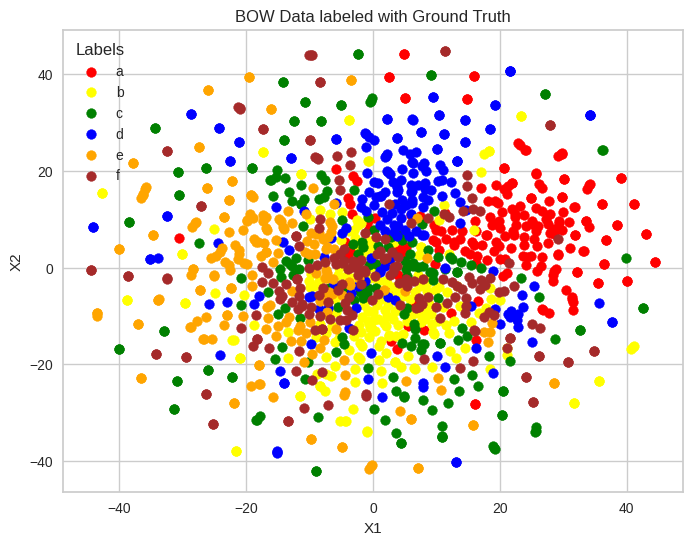

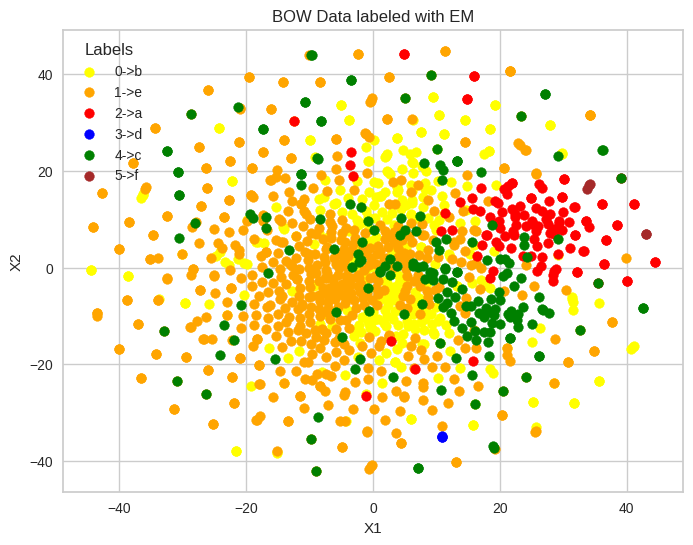

In [108]:
# Plot
plotData(data_BOW_pca_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_pca_tsne,em_BOW_cluster_labels,np.unique(em_BOW_cluster_labels),em_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with EM')

###**EM with tfidf**

In [109]:
# Get PCA reduced data since EM uses a lot of memory and crashes due to no more RAM
# Perform PCA (w/o limits on n_components)
pca = PCA(random_state=42)
data_tfidf_pca = pca.fit_transform(data_tfidf)

# Convert back to DataFrame for readability
data_tfidf_pca = pd.DataFrame(data=data_tfidf_pca)

In [110]:
# Plot the explained variance ratio for each principal component.
# Look for the "elbow" point in the plot, where the explained variance starts to level off.
# Select the number of components corresponding to the "elbow" point.
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [111]:
# Keep only the first 1000 components since they explain the majority of the variance in the data. Components after the elbow explain relatively little additional variance
data_tfidf_pca = data_tfidf_pca.iloc[:,:1000]

In [112]:
em_tfidf_cluster_labels= perform_em(data_tfidf_pca,6)

In [113]:
# Evaluate metrics
em_tfidf_metrics= evaluate_clusterer(data_tfidf_pca,data['Label'],em_tfidf_cluster_labels)
em_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.002554  0.408  -3.271285

In [114]:
# Check which majority authors the cluster labels correspond to
em_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_tfidf_cluster_labels)
em_tfidf_cluster_to_majority_author

{0: 'f', 1: 'e', 2: 'd', 3: 'c', 4: 'a', 5: 'b'}

In [115]:
# Transform data to 2D tsne to plot
data_tfidf_pca_tsne= get_TSNE(data_tfidf_pca)

Text(0.5, 1.0, 'tfidf Data labeled with EM')

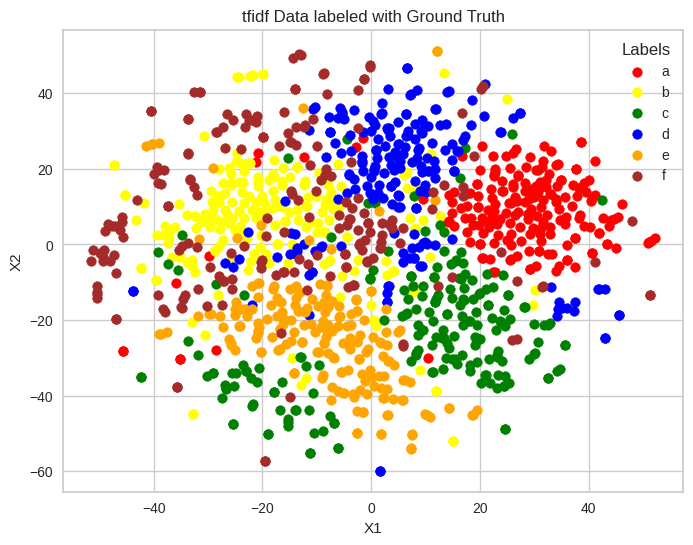

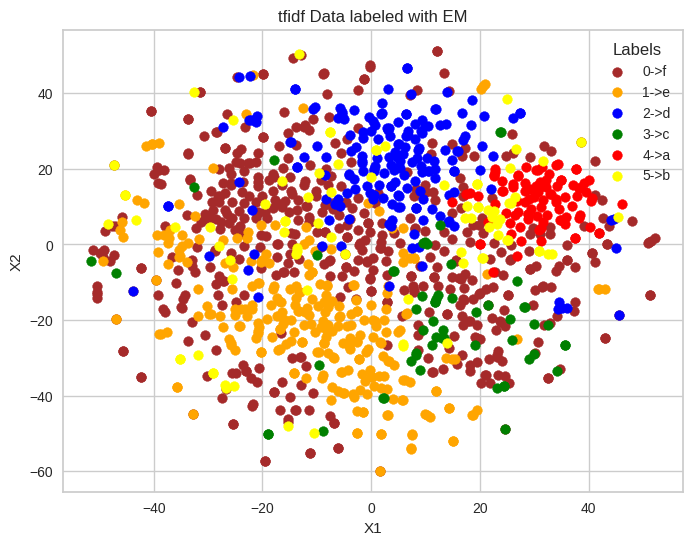

In [116]:
# Plot
plotData(data_tfidf_pca_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_pca_tsne,em_tfidf_cluster_labels,np.unique(em_tfidf_cluster_labels),em_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with EM')

###**EM with doc2vec**

In [117]:
em_d2v_cluster_labels= perform_em(data_d2v,6)

In [118]:
# Evaluate metrics
em_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],em_d2v_cluster_labels)
em_d2v_metrics

Silhouette  Kappa  Coherence
0    0.038876  0.615  -2.555581

In [119]:
# Check which majority authors the cluster labels correspond to
em_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_d2v_cluster_labels)
em_d2v_cluster_to_majority_author

{0: 'c', 1: 'e', 2: 'd', 3: 'a', 4: 'f', 5: 'b'}

Text(0.5, 1.0, 'd2v Data labeled with EM')

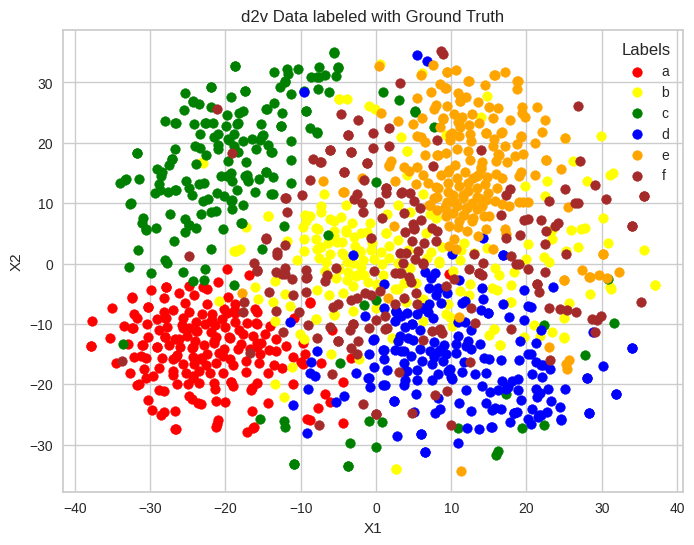

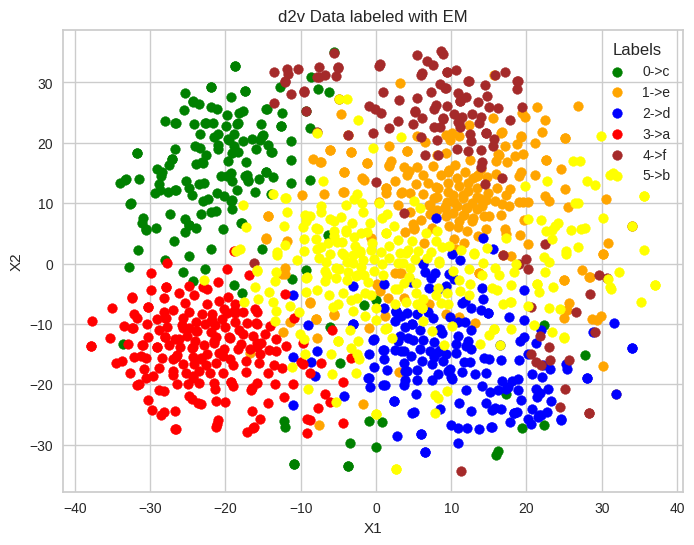

In [120]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,em_d2v_cluster_labels,np.unique(em_d2v_cluster_labels),em_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with EM')

###**EM with lda**

In [121]:
em_lda_cluster_labels= perform_em(data_lda,6)

In [122]:
# Evaluate metrics
em_lda_metrics= evaluate_clusterer(data_lda,data['Label'],em_lda_cluster_labels)
em_lda_metrics

Silhouette  Kappa  Coherence
0    0.152739  0.221  -3.596267

In [123]:
# Check which majority authors the cluster labels correspond to
em_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_lda_cluster_labels)
em_lda_cluster_to_majority_author

{0: 'b', 1: 'e', 2: 'd', 3: 'c', 4: 'a', 5: 'f'}

In [124]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,em_lda_cluster_labels,np.unique(em_lda_cluster_labels),em_lda_cluster_to_majority_author)
plt.title('lda Data labeled with EM')

Text(0.5, 1.0, 'lda Data labeled with EM')

### **EM Metrics**

In [125]:
em_metrics = pd.concat([em_BOW_metrics,em_tfidf_metrics,em_d2v_metrics,em_lda_metrics]).reset_index(drop=True)
em_metrics.index=['BOW','TFIDF','doc2vec','LDA']
em_metrics

Silhouette  Kappa  Coherence
BOW        0.004438  0.207  -1.968713
TFIDF      0.002554  0.408  -3.271285
doc2vec    0.038876  0.615  -2.555581
LDA        0.152739  0.221  -3.596267

# **Champion Model**

In [126]:
all_models = pd.concat([kmeans_metrics,hc_metrics,em_metrics])
print("Order: Kmeans, Hierarchical clustering, EM")
all_models


Order: Kmeans, Hierarchical clustering, EM


Silhouette  Kappa  Coherence
BOW        0.004710  0.226  -3.153903
TFIDF      0.005352  0.631  -2.221145
doc2vec    0.043722  0.774  -2.215274
LDA        0.607482  0.366  -4.433112
BOW        0.001546  0.336  -3.225656
TFIDF      0.003985  0.545  -1.959005
doc2vec    0.025830  0.526  -2.862588
LDA        0.578091  0.365  -5.000248
BOW        0.004438  0.207  -1.968713
TFIDF      0.002554  0.408  -3.271285
doc2vec    0.038876  0.615  -2.555581
LDA        0.152739  0.221  -3.596267

Based on Cohen Kappa Scores, and t-SNE plots, K-Means Clustering with Doc2Vec vectorized data resulted in the highest agreement with the ground truth labels. Therefore, it's our champion model.

# **Error Analysis of Champion Model**

In [152]:
# Convert obtained k-means cluster labels to author assignments
author_assign=[]
for cluster in kmeans_d2v_cluster_labels:
  author_assign.append(kmeans_d2v_cluster_to_majority_author[cluster])
author_assign=pd.Series(author_assign)

In [153]:
author_assign

0       f
1       a
2       a
3       a
4       a
       ..
1195    f
1196    f
1197    b
1198    f
1199    f
Length: 1200, dtype: object

In [154]:
# Get wrongly assigned partitions
wrong=data[data['Label']!=author_assign]
wrong

Book Title         Book Author Label  \
0                   Pride and Prejudice         Jane Austen     a   
116                 Pride and Prejudice         Jane Austen     a   
122                 Pride and Prejudice         Jane Austen     a   
128                 Pride and Prejudice         Jane Austen     a   
181                 Pride and Prejudice         Jane Austen     a   
...                                 ...                 ...   ...   
1182  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1189  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1192  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1194  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   
1197  The Adventures of Sherlock Holmes  Arthur Conan Doyle     f   

                                              Partition  \
0     library ) he started back , and , begging pard...   
116   belief of my indifference ? ” “ None at all . ...   
122   very monotonous solemnity , read three pages ,...   
128   Mr. Darcy , it is very ungenerous in you to me...   
181   I can not find out that I hate her at all , or...   
...                                                 ...   
1182  , ” he gasped . “ Not at all . Drink this. ” I...   
1189  glance that he was in the grip of some deadly ...   
1192  . It was all done in an instant , and there wa...   
1194  dangerous company which he was keeping , but e...   
1197  , “ I say now , as I said then , that a man sh...   

                                      Partition_stemmed  \
0     librari start back beg pardon protest never re...   
116   belief indiffer none know proud unpleas sort m...   
122   monoton solemn read three page interrupt know ...   
128   mr darci ungener mention knew disadvantag hert...   
181   find hate least unwil think good sort girl lov...   
...                                                 ...   
1182  gasp drink dash brandi water colour began come...   
1189  glanc grip deadli chronic diseas pray sit sofa...   
1192  done instant gentleman thank one side ladi cle...   
1194  danger compani keep time influenc friend sir g...   
1197  say said man keep littl brainatt stock furnitu...   

                                   Partition_lemmatized  Word_count  \
0     library started back begging pardon protested ...          64   
116   belief indifference none know proud unpleasant...          44   
122   monotonous solemnity read three page interrupt...          65   
128   mr darcy ungenerous mention knew disadvantage ...          52   
181   find hate least unwilling think good sort girl...          53   
...                                                 ...         ...   
1182  gasped drink dashed brandy water colour began ...          54   
1189  glance grip deadly chronic disease pray sit so...          56   
1192  done instant gentleman thanking one side lady ...          49   
1194  dangerous company keeping time influence frien...          59   
1197  say said man keep little brainattic stocked fu...          59   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 358        1.551846         5.593750             1.480429   
116               248        1.584893         5.636364             1.344902   
122               372        1.515717         5.723077             1.520424   
128               309        1.475773         5.942308             1.493417   
181               350        1.515717         6.603774             1.459611   
...               ...             ...              ...                  ...   
1182              303        1.670278         5.611111             1.329505   
1189              292        1.643752         5.214286             1.360822   
1192              310        1.430969         6.326531             1.521980   
1194              350        1.319508         5.932203             1.713004   
1197              324        1.475773         5.491525      

In [155]:
wrong.shape

(226, 13)

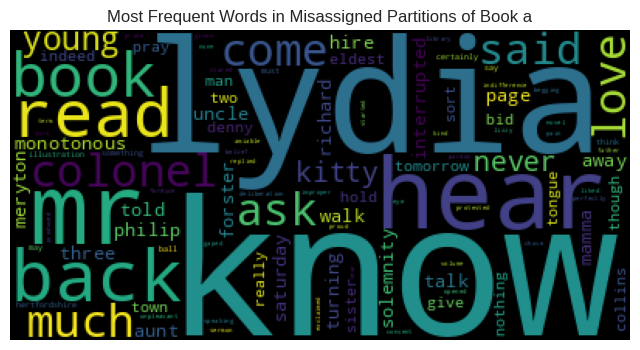

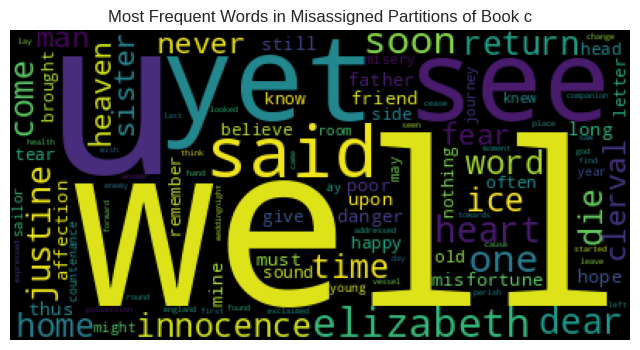

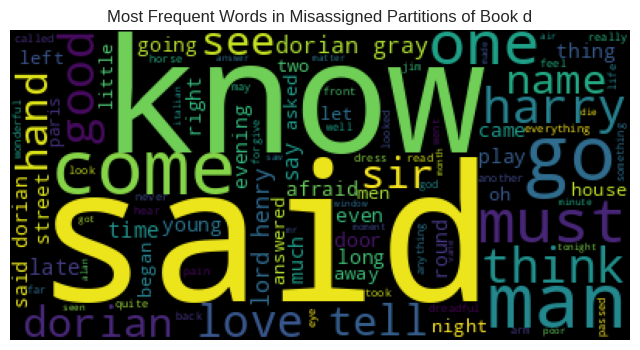

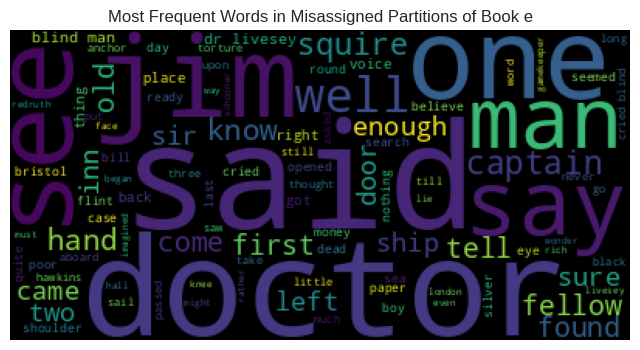

In [156]:
# Most frequent words in wrongly assigned partitions
for y in wrong['Label'].unique():
  corpus = wrong[wrong['Label']==y]['Partition_lemmatized']
  corpus = ' '.join([word for doc in corpus for word in get_tokens(doc)])
  wc = wordcloud.WordCloud(background_color='black', max_words=100)
  wc = wc.generate(corpus)
  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title('Most Frequent Words in Misassigned Partitions of Book {}'.format(y))
  plt.imshow(wc, cmap=None)
  plt.show()

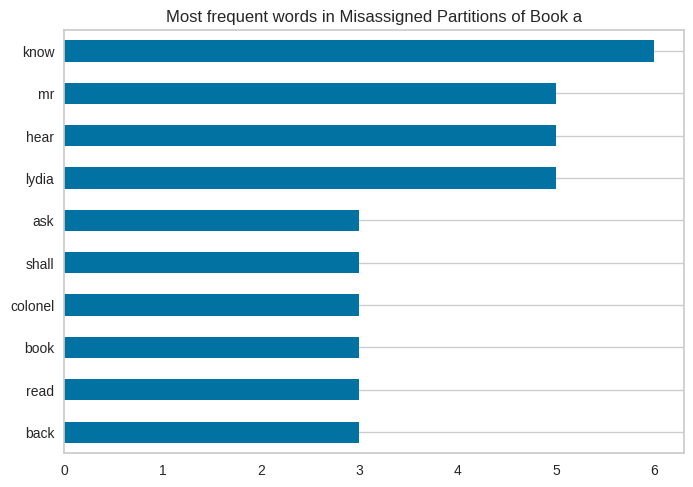

In [157]:
# Top 10 words in misassigned partitions
top= 10
for y in data['Label'].unique():
  corpus = wrong[wrong['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  plt.figure()
  ax = plt.gca()
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Most frequent words in Misassigned Partitions of Book {}".format(y), ax=ax,legend=False).grid(axis='x')
  ax.set(ylabel=None)

In [158]:
# Most frequent collocations in misassigned partitions
for y in data['Label'].unique():
  top_collocations= find_top_collocations(wrong,y)
  print('Top 10 collocations of Misassigned Partitions of Book {}: {}'.format(y,top_collocations))

Top 10 collocations of Misassigned Partitions of Book a: []
Top 10 collocations of Misassigned Partitions of Book b: [('van', 'helsing'), ('dr', 'seward'), ('woman', 'winked'), ('achaffin', 'ye'), ('briskly', 'ye'), ('ye', 'excoose'), ('mr', 'bilder'), ('seward', 'diary'), ('winked', 'much'), ('old', 'gent')]
Top 10 collocations of Misassigned Partitions of Book c: [('accident', 'happened')]
Top 10 collocations of Misassigned Partitions of Book d: [('basil', 'hallward'), ('mr', 'hubbard'), ('shook', 'head'), ('lord', 'henry'), ('dorian', 'gray'), ('said', 'dorian')]
Top 10 collocations of Misassigned Partitions of Book e: [('find', 'em'), ('ready', 'sea'), ('dr', 'livesey'), ('cried', 'blind'), ('blind', 'man'), ('could', 'see'), ('doctor', 'said')]
Top 10 collocations of Misassigned Partitions of Book f: [('george', 'burnwell'), ('miss', 'stoner'), ('lord', 'st'), ('st', 'simon'), ('doubted', 'frank'), ('sir', 'george'), ('young', 'lady'), ('dead', 'lord'), ('never', 'doubted'), ('rea

Confusion matrix

In [135]:
def error_analysis(label_mapping,cluster_label,type_):
  mapped_data = np.array([label_mapping[value] for value in cluster_label])
  conf_matrix = confusion_matrix(data["Label"],mapped_data)
  #f1_ = f1_score(mapped_data,data["Label"],average = "micro")
  class_report = classification_report(mapped_data,data["Label"])
  display_results(conf_matrix, class_report,type_)
  return conf_matrix, class_report

In [136]:
def display_results(conf_matrix,class_report,type_):
  print(type_)
  print(conf_matrix)
  print(class_report)

In [137]:
kmeans_bow_conf_matrix, kmeans_bow_report = error_analysis(kmeans_BOW_cluster_to_majority_author,kmeans_BOW_cluster_labels,type_ = "KMEANS BOW")

KMEANS BOW
[[108   2  16  28  13  33]
 [  2  27  48  59  37  27]
 [  1  14 138   1  24  22]
 [  2   3  53  84  40  18]
 [  0   3 130  20  29  18]
 [  9   2  84  31  34  40]]
              precision    recall  f1-score   support

           a       0.54      0.89      0.67       122
           b       0.14      0.53      0.22        51
           c       0.69      0.29      0.41       469
           d       0.42      0.38      0.40       223
           e       0.14      0.16      0.15       177
           f       0.20      0.25      0.22       158

    accuracy                           0.36      1200
   macro avg       0.35      0.42      0.35      1200
weighted avg       0.46      0.35      0.36      1200



In [138]:
kmeans_tfidf_conf_matrix, kmeans_tfidf_report = error_analysis(kmeans_tfidf_cluster_to_majority_author,kmeans_tfidf_cluster_labels,type_ = "KMEANS tfidf")

KMEANS tfidf
[[159   4  33   1   0   3]
 [  0  90  20   4  15  71]
 [  1  11 174   0   3  11]
 [  0  13  14 138   2  33]
 [  0   2   4   2 146  46]
 [  2  27  25  12  10 124]]
              precision    recall  f1-score   support

           a       0.80      0.98      0.88       162
           b       0.45      0.61      0.52       147
           c       0.87      0.64      0.74       270
           d       0.69      0.88      0.77       157
           e       0.73      0.83      0.78       176
           f       0.62      0.43      0.51       288

    accuracy                           0.69      1200
   macro avg       0.69      0.73      0.70      1200
weighted avg       0.70      0.69      0.69      1200



In [139]:
kmeans_d2v_conf_matrix, kmeans_d2v_report = error_analysis(kmeans_d2v_cluster_to_majority_author,kmeans_d2v_cluster_labels,type_ = "KMEANS d2v")

KMEANS d2v
[[195   2   0   1   0   2]
 [  3 131   2   6  21  37]
 [  6   7 172   1   5   9]
 [  1  17   1 170   5   6]
 [  0  10   0   4 171  15]
 [  2  41   4  10   8 135]]
              precision    recall  f1-score   support

           a       0.97      0.94      0.96       207
           b       0.66      0.63      0.64       208
           c       0.86      0.96      0.91       179
           d       0.85      0.89      0.87       192
           e       0.85      0.81      0.83       210
           f       0.68      0.66      0.67       204

    accuracy                           0.81      1200
   macro avg       0.81      0.82      0.81      1200
weighted avg       0.81      0.81      0.81      1200



In [140]:
kmeans_lda_conf_matrix, kmeans_lda_report = error_analysis(kmeans_lda_cluster_to_majority_author,kmeans_lda_cluster_labels,type_ = "KMEANS LDA")

KMEANS LDA
[[188   4   7   0   1   0]
 [ 13  14  22  20 124   7]
 [  3  23 105  20  16  33]
 [ 64   5  12  68  41  10]
 [  0   6   4   6 179   5]
 [ 34   8  26  20 100  12]]
              precision    recall  f1-score   support

           a       0.94      0.62      0.75       302
           b       0.07      0.23      0.11        60
           c       0.53      0.60      0.56       176
           d       0.34      0.51      0.41       134
           e       0.90      0.39      0.54       461
           f       0.06      0.18      0.09        67

    accuracy                           0.47      1200
   macro avg       0.47      0.42      0.41      1200
weighted avg       0.70      0.47      0.53      1200



In [141]:
hc_bow_conf_matrix, hc_bow_report = error_analysis(hc_BOW_cluster_to_majority_author,hc_BOW_cluster_labels,type_ = "hc BOW")

hc BOW
[[ 99  30  49   7   0  15]
 [  0  88  95   8   3   6]
 [  0  13 157  12   0  18]
 [  0  23  47 110   5  15]
 [  0   9 107   3  73   8]
 [  2  65 116   8   0   9]]
              precision    recall  f1-score   support

           a       0.49      0.98      0.66       101
           b       0.44      0.39      0.41       228
           c       0.79      0.27      0.41       571
           d       0.55      0.74      0.63       148
           e       0.36      0.90      0.52        81
           f       0.04      0.13      0.07        71

    accuracy                           0.45      1200
   macro avg       0.45      0.57      0.45      1200
weighted avg       0.59      0.45      0.44      1200



In [142]:
hc_tfidf_conf_matrix, hc_fidf_report = error_analysis(hc_tfidf_cluster_to_majority_author,hc_tfidf_cluster_labels,type_ = "HC TFIDF")

HC TFIDF
[[147   4   3   0   4  42]
 [  0   0   9   0  19 172]
 [  1   0 175   0   9  15]
 [  0   0  16  69  18  97]
 [  0   0   1   0 170  29]
 [  2   0   3   0  11 184]]
              precision    recall  f1-score   support

           a       0.73      0.98      0.84       150
           b       0.00      0.00      0.00         4
           c       0.88      0.85      0.86       207
           d       0.34      1.00      0.51        69
           e       0.85      0.74      0.79       231
           f       0.92      0.34      0.50       539

    accuracy                           0.62      1200
   macro avg       0.62      0.65      0.58      1200
weighted avg       0.84      0.62      0.66      1200



In [143]:
hc_d2v_conf_matrix, hc_d2v_report = error_analysis(hc_d2v_cluster_to_majority_author,hc_d2v_cluster_labels,type_ = "HC D2V")


HC D2V
[[134  56   1   0   0   9]
 [  1 122   6   1  15  55]
 [  4  21 164   4   4   3]
 [  1 119   2  66   3   9]
 [  0  19   3   2 136  40]
 [  1  75  13   1   6 104]]
              precision    recall  f1-score   support

           a       0.67      0.95      0.79       141
           b       0.61      0.30      0.40       412
           c       0.82      0.87      0.84       189
           d       0.33      0.89      0.48        74
           e       0.68      0.83      0.75       164
           f       0.52      0.47      0.50       220

    accuracy                           0.60      1200
   macro avg       0.61      0.72      0.63      1200
weighted avg       0.63      0.60      0.58      1200



In [144]:
hc_lda_conf_matrix, hc_lda_report = error_analysis(hc_lda_cluster_to_majority_author,hc_lda_cluster_labels,type_ = "HC LDA")


HC LDA
[[182   4  11   0   3   0]
 [ 10  12  15  18 140   5]
 [  5  21 108  14  22  30]
 [ 60   5  12  69  49   5]
 [  0   6   0   5 186   3]
 [ 16   8  29  17 122   8]]
              precision    recall  f1-score   support

           a       0.91      0.67      0.77       273
           b       0.06      0.21      0.09        56
           c       0.54      0.62      0.58       175
           d       0.34      0.56      0.43       123
           e       0.93      0.36      0.52       522
           f       0.04      0.16      0.06        51

    accuracy                           0.47      1200
   macro avg       0.47      0.43      0.41      1200
weighted avg       0.73      0.47      0.53      1200



In [145]:
EM_bow_conf_matrix, EM_bow_report = error_analysis(em_BOW_cluster_to_majority_author,em_BOW_cluster_labels,type_ = "EM BOW")


EM BOW
[[108  31  28   0  28   5]
 [  1  98  19   0  82   0]
 [  1  14  52   3 130   0]
 [  2  84  30   0  84   0]
 [  0  34  17   0 149   0]
 [  8  42  38   0 112   0]]
              precision    recall  f1-score   support

           a       0.54      0.90      0.68       120
           b       0.49      0.32      0.39       303
           c       0.26      0.28      0.27       184
           d       0.00      0.00      0.00         3
           e       0.74      0.25      0.38       585
           f       0.00      0.00      0.00         5

    accuracy                           0.34      1200
   macro avg       0.34      0.29      0.29      1200
weighted avg       0.58      0.34      0.39      1200



In [146]:
em_tfidf_conf_matrix, em_tfidf_report = error_analysis(em_tfidf_cluster_to_majority_author,em_tfidf_cluster_labels,type_ = "em tfidf")


em tfidf
[[ 93  32   0  17   0  58]
 [  0  17   4  16  31 132]
 [  0  13  40   0  11 136]
 [  0   9   5 130  23  33]
 [  0   0   2   1 189   8]
 [  0  11   6  19  25 139]]
              precision    recall  f1-score   support

           a       0.47      1.00      0.63        93
           b       0.09      0.21      0.12        82
           c       0.20      0.70      0.31        57
           d       0.65      0.71      0.68       183
           e       0.94      0.68      0.79       279
           f       0.69      0.27      0.39       506

    accuracy                           0.51      1200
   macro avg       0.51      0.60      0.49      1200
weighted avg       0.66      0.51      0.53      1200



In [147]:
em_d2v_conf_matrix, em_d2v_report = error_analysis(em_d2v_cluster_to_majority_author,em_d2v_cluster_labels,type_ = "EM D2V")


EM D2V
[[195   1   0   2   2   0]
 [  5 151   2   6  26  10]
 [  3   6 164   2   0  25]
 [  2  19   0 162   5  12]
 [  0   4   1   3 127  65]
 [  2  90   7  16  69  16]]
              precision    recall  f1-score   support

           a       0.97      0.94      0.96       207
           b       0.76      0.56      0.64       271
           c       0.82      0.94      0.88       174
           d       0.81      0.85      0.83       191
           e       0.64      0.55      0.59       229
           f       0.08      0.12      0.10       128

    accuracy                           0.68      1200
   macro avg       0.68      0.66      0.67      1200
weighted avg       0.72      0.68      0.69      1200



In [148]:
em_lda_conf_matrix, em_lda_report = error_analysis(em_lda_cluster_to_majority_author,em_lda_cluster_labels,type_ = "EM LDA")


EM LDA
[[116   5   2  36   0  41]
 [  1  12  10  26  75  76]
 [  1  32  54  21  13  79]
 [ 24  17  37  37  58  27]
 [  0   8   1   6 116  69]
 [  4  12  26  20  52  86]]
              precision    recall  f1-score   support

           a       0.58      0.79      0.67       146
           b       0.06      0.14      0.08        86
           c       0.27      0.42      0.33       130
           d       0.18      0.25      0.21       146
           e       0.58      0.37      0.45       314
           f       0.43      0.23      0.30       378

    accuracy                           0.35      1200
   macro avg       0.35      0.37      0.34      1200
weighted avg       0.41      0.35      0.36      1200

